In [1]:
import numpy as np
import pandas as pd
import os, gc
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import date, datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from scipy.optimize import nnls
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# note: all data update 2020-04-01, china rule
mname = 'gbt1n'
path = '/kaggle/input/gbt1n-external/'
pathk = '/kaggle/input/covid19-global-forecasting-week-2/'
nhorizon = 30
skip = 0
# kv = [3]
# kv = [6]
kv = [6,11]
# kv = [13]
train_full = True
save_data = False

# booster = ['lgb','xgb']
booster = ['lgb','xgb','ctb']
# booster = ['cas']

# if using updated daily data, also update time-varying external data
# in COVID-19 and covid-19-data, git pull origin master 
# ecdc wget https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
# weather: https://www.kaggle.com/davidbnn92/weather-data/output?scriptVersionId=31103959
# google trends: pytrends0b.ipynb

In [3]:
train = pd.read_csv(pathk+'train.csv')
test = pd.read_csv(pathk+'test.csv')
ss = pd.read_csv(pathk+'submission.csv')

In [4]:
train

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
20575,29366,NaN,Zimbabwe,2020-03-27,5.0,1.0
20576,29367,NaN,Zimbabwe,2020-03-28,7.0,1.0
20577,29368,NaN,Zimbabwe,2020-03-29,7.0,1.0
20578,29369,NaN,Zimbabwe,2020-03-30,7.0,1.0


In [5]:
# tmax and dmax are the last day of training
tmax = train.Date.max()
dmax = datetime.strptime(tmax,'%Y-%m-%d').date()
print(tmax, dmax)

2020-03-31 2020-03-31


In [6]:
# ddate is the last day of validation training
ddate = dmax - timedelta(days=nhorizon)
ddate

datetime.date(2020, 3, 1)

In [7]:
test

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23
...,...,...,...,...
12637,12638,NaN,Zimbabwe,2020-04-26
12638,12639,NaN,Zimbabwe,2020-04-27
12639,12640,NaN,Zimbabwe,2020-04-28
12640,12641,NaN,Zimbabwe,2020-04-29


In [8]:
fmax = test.Date.max()
fdate = datetime.strptime(fmax,'%Y-%m-%d').date()
fdate

datetime.date(2020, 4, 30)

In [9]:
tmin = train.Date.min()
fmin = test.Date.min()
tmin, fmin

('2020-01-22', '2020-03-19')

In [10]:
dmin = datetime.strptime(tmin,'%Y-%m-%d').date()
print(dmin)

2020-01-22


In [11]:
# train['ForecastId'] = train.Id - train.Id.max()
cp = ['Country_Region','Province_State']
cpd = cp + ['Date']
train = train.merge(test[cpd+['ForecastId']], how='left', on=cpd)
train['ForecastId'] = train['ForecastId'].fillna(0).astype(int)
train['y0_pred'] = np.nan
train['y1_pred'] = np.nan

test['Id'] = test.ForecastId + train.Id.max()
test['ConfirmedCases'] = np.nan
test['Fatalities'] = np.nan
# use zeros here instead of nans so monotonic adjustment fills final dates if necessary
test['y0_pred'] = 0.0
test['y1_pred'] = 0.0

In [12]:
# concat non-overlapping part of test to train for feature engineering
d = pd.concat((train,test[test.Date > train.Date.max()])).reset_index(drop=True)
d

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,Id,Province_State,y0_pred,y1_pred
0,0.0,Afghanistan,2020-01-22,0.0,0,1,NaN,NaN,NaN
1,0.0,Afghanistan,2020-01-23,0.0,0,2,NaN,NaN,NaN
2,0.0,Afghanistan,2020-01-24,0.0,0,3,NaN,NaN,NaN
3,0.0,Afghanistan,2020-01-25,0.0,0,4,NaN,NaN,NaN
4,0.0,Afghanistan,2020-01-26,0.0,0,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,42008,NaN,0.0,0.0
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,42009,NaN,0.0,0.0
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,42010,NaN,0.0,0.0
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,42011,NaN,0.0,0.0


In [13]:
(dmin + timedelta(30)).isoformat()

'2020-02-21'

In [14]:
d['Date'].value_counts().std()

0.0

In [15]:
# fill missing province with blank, must also do this with external data before merging
d[cp] = d[cp].fillna('')

# create single location variable
d['Loc'] = d['Country_Region'] + ' ' + d['Province_State']
d['Loc'] = d['Loc'].str.strip()
d['Loc'].value_counts()

Chile                            100
Turkey                           100
Fiji                             100
China Gansu                      100
US Connecticut                   100
                                ... 
United Kingdom                   100
Guyana                           100
US North Dakota                  100
US Oklahoma                      100
United Kingdom Cayman Islands    100
Name: Loc, Length: 294, dtype: int64

In [16]:
# sort by location then date
d = d.sort_values(['Loc','Date']).reset_index(drop=True)

In [17]:
d['Country_Region'].value_counts(dropna=False)

US                        5400
China                     3300
France                    1000
Canada                    1000
Australia                  800
                          ... 
Guyana                     100
Bosnia and Herzegovina     100
Hungary                    100
Uganda                     100
Burkina Faso               100
Name: Country_Region, Length: 173, dtype: int64

In [18]:
d['Province_State'].value_counts(dropna=False)

                  16900
Connecticut         100
Guam                100
Heilongjiang        100
Arizona             100
                  ...  
Delaware            100
Virgin Islands      100
Maine               100
California          100
Utah                100
Name: Province_State, Length: 126, dtype: int64

In [19]:
gt = pd.read_csv(path+'google_trends.csv')
gt[cp] = gt[cp].fillna('')
gt

,Country_Region,Province_State,coronavirus,country_code,covid-19,covid19,Date
0,Afghanistan,,3.0,AF,0.0,0.0,2020-01-22
1,Afghanistan,,3.0,AF,0.0,0.0,2020-01-23
2,Afghanistan,,5.0,AF,0.0,0.0,2020-01-24
3,Afghanistan,,11.0,AF,0.0,0.0,2020-01-25
4,Afghanistan,,8.0,AF,0.0,0.0,2020-01-26
...,...,...,...,...,...,...,...
17698,US,Virgin Islands,56.0,VI,10.0,0.0,2020-03-20
17699,US,Virgin Islands,50.0,VI,6.0,0.0,2020-03-21
17700,US,Virgin Islands,53.0,VI,6.0,5.0,2020-03-22
17701,US,Virgin Islands,53.0,VI,10.0,0.0,2020-03-23


In [20]:
# since trends data lags behind a day or two, shift the date to make it contemporaneous
gmax = gt.Date.max()
gmax = datetime.strptime(gmax,'%Y-%m-%d').date()
goff = (dmax - gmax).days
print(dmax, gmax, goff)
gt['Date'] = (pd.to_datetime(gt.Date) + timedelta(goff)).dt.strftime('%Y-%m-%d')
gt['google_covid'] = gt['coronavirus'] + gt['covid-19'] + gt['covid19']
gt.drop(['coronavirus','covid-19','covid19'], axis=1, inplace=True)
google = ['google_covid']
gt

2020-03-31 2020-03-24 7


,Country_Region,Province_State,country_code,Date,google_covid
0,Afghanistan,,AF,2020-01-29,3.0
1,Afghanistan,,AF,2020-01-30,3.0
2,Afghanistan,,AF,2020-01-31,5.0
3,Afghanistan,,AF,2020-02-01,11.0
4,Afghanistan,,AF,2020-02-02,8.0
...,...,...,...,...,...
17698,US,Virgin Islands,VI,2020-03-27,66.0
17699,US,Virgin Islands,VI,2020-03-28,56.0
17700,US,Virgin Islands,VI,2020-03-29,64.0
17701,US,Virgin Islands,VI,2020-03-30,63.0


In [21]:
d = d.merge(gt, how='left', on=['Country_Region','Province_State','Date'])
d

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,...,y0_pred,y1_pred,Loc,country_code,google_covid
0,0.0,Afghanistan,2020-01-22,0.0,0,...,NaN,NaN,Afghanistan,NaN,NaN
1,0.0,Afghanistan,2020-01-23,0.0,0,...,NaN,NaN,Afghanistan,NaN,NaN
2,0.0,Afghanistan,2020-01-24,0.0,0,...,NaN,NaN,Afghanistan,NaN,NaN
3,0.0,Afghanistan,2020-01-25,0.0,0,...,NaN,NaN,Afghanistan,NaN,NaN
4,0.0,Afghanistan,2020-01-26,0.0,0,...,NaN,NaN,Afghanistan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,...,0.0,0.0,Zimbabwe,NaN,NaN
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,...,0.0,0.0,Zimbabwe,NaN,NaN
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,...,0.0,0.0,Zimbabwe,NaN,NaN
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,...,0.0,0.0,Zimbabwe,NaN,NaN


In [22]:
d['google_covid'].describe()

count    17703.000000
mean        29.041462
std         30.720911
min          0.000000
25%          6.000000
50%         15.000000
75%         44.000000
max        187.000000
Name: google_covid, dtype: float64

In [23]:
# merge country info
country = pd.read_csv(path+'covid19countryinfo1.csv')
# country["pop"] = country["pop"].str.replace(",","").astype(float)
country

,country,pop,tests,pop/tests,testpop,...,sex65plus,sexratio,lung,femalelung,malelung
0,Afghanistan,38928346.0,NaN,NaN,NaN,...,0.85,1.03,37.62,36.31,39.33
1,Albania,2877797.0,NaN,NaN,NaN,...,0.87,0.98,11.67,7.02,17.04
2,Algeria,43851044.0,NaN,NaN,NaN,...,0.89,1.03,8.77,5.03,12.81
3,Andorra,77265.0,NaN,NaN,NaN,...,1.02,1.06,NaN,NaN,NaN
4,Antigua and Barbuda,97929.0,NaN,NaN,NaN,...,0.76,0.90,11.76,7.67,18.78
...,...,...,...,...,...,...,...,...,...,...,...
232,Ontario,14446515.0,19511.0,740.429245,740.429245,...,NaN,NaN,NaN,NaN,NaN
233,Quebec,8433301.0,10451.0,806.937231,806.937231,...,NaN,NaN,NaN,NaN,NaN
234,Saskatchewan,1168423.0,2561.0,456.237017,456.237017,...,NaN,NaN,NaN,NaN,NaN
235,Guangdong,113460000.0,320000.0,354.562500,354.562500,...,NaN,NaN,NaN,NaN,NaN


In [24]:
country.columns

Index(['country', 'pop', 'tests', 'pop/tests', 'testpop', 'density',
       'medianage', 'urbanpop', 'quarantine', 'schools', 'restrictions',
       'hospibed', 'smokers', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64',
       'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung'],
      dtype='object')

In [25]:
d.shape

(29400, 12)

In [26]:
# first merge by country
d = d.merge(country.loc[country.medianage.notnull(),['country','pop','testpop','medianage']],
            how='left', left_on='Country_Region', right_on='country')
d

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,...,google_covid,country,pop,testpop,medianage
0,0.0,Afghanistan,2020-01-22,0.0,0,...,NaN,Afghanistan,38928346.0,NaN,18.0
1,0.0,Afghanistan,2020-01-23,0.0,0,...,NaN,Afghanistan,38928346.0,NaN,18.0
2,0.0,Afghanistan,2020-01-24,0.0,0,...,NaN,Afghanistan,38928346.0,NaN,18.0
3,0.0,Afghanistan,2020-01-25,0.0,0,...,NaN,Afghanistan,38928346.0,NaN,18.0
4,0.0,Afghanistan,2020-01-26,0.0,0,...,NaN,Afghanistan,38928346.0,NaN,18.0
...,...,...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,...,NaN,NaN,NaN,NaN,NaN
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,...,NaN,NaN,NaN,NaN,NaN
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,...,NaN,NaN,NaN,NaN,NaN
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,...,NaN,NaN,NaN,NaN,NaN


In [27]:
# then merge by province
c1 = country.loc[country.medianage.isnull(),['country','pop','testpop']]
print(c1.shape)
c1.columns = ['Province_State','pop1','testpop1']
# d.update(c1)
d = d.merge(c1,how='left',on='Province_State')
d.loc[d.pop1.notnull(),'pop'] = d.loc[d.pop1.notnull(),'pop1']
d.loc[d.testpop1.notnull(),'testpop'] = d.loc[d.testpop1.notnull(),'testpop1']
d.drop(['pop1','testpop1'], axis=1, inplace=True)
print(d.shape)
print(d.loc[(d.Date=='2020-03-25') & (d['Province_State']=='New York')])

(73, 3)
(29400, 16)
       ConfirmedCases Country_Region        Date  Fatalities  ForecastId  ...  \
25763         30841.0             US  2020-03-25       285.0       11058  ...   

       google_covid country         pop     testpop medianage  
25763          79.0      US  19542209.0  214.114265      38.0  

[1 rows x 16 columns]


In [28]:
# testing data time series, us states only, would love to have this for all countries
ct = pd.read_csv(path+'states_daily_4pm_et.csv')
si = pd.read_csv(path+'states_info.csv')
si = si.rename(columns={'name':'Province_State'})
ct = ct.merge(si[['state','Province_State']], how='left', on='state')
ct['Date'] = ct['date'].apply(str).transform(lambda x: '-'.join([x[:4], x[4:6], x[6:]]))
ct.loc[ct.Province_State=='US Virgin Islands','Province_State'] = 'Virgin Islands'
ct.loc[ct.Province_State=='District Of Columbia','Province_State'] = 'District of Columbia'
pd.set_option('display.max_rows', 20)
ct
# ct = ct['Date','state','total']

,date,state,positive,negative,pending,...,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Province_State,Date
0,20200329,AK,102.0,3232.0,NaN,...,396.0,17.0,413.0,Alaska,2020-03-29
1,20200329,AL,806.0,4184.0,NaN,...,0.0,110.0,110.0,Alabama,2020-03-29
2,20200329,AR,426.0,3027.0,NaN,...,89.0,22.0,111.0,Arkansas,2020-03-29
3,20200329,AS,NaN,NaN,NaN,...,0.0,0.0,0.0,American Samoa,2020-03-29
4,20200329,AZ,919.0,12953.0,NaN,...,5498.0,46.0,5544.0,Arizona,2020-03-29
...,...,...,...,...,...,...,...,...,...,...,...
1312,20200304,OR,3.0,29.0,18.0,...,NaN,NaN,NaN,Oregon,2020-03-04
1313,20200304,SC,0.0,5.0,0.0,...,NaN,NaN,NaN,South Carolina,2020-03-04
1314,20200304,TX,1.0,NaN,NaN,...,NaN,NaN,NaN,Texas,2020-03-04
1315,20200304,WA,39.0,NaN,NaN,...,NaN,NaN,NaN,Washington,2020-03-04


In [29]:
ckeep = ['positive','negative','totalTestResults']
for c in ckeep: ct[c] = np.log1p(ct[c])

In [30]:
d = d.merge(ct[['Province_State','Date']+ckeep], how='left',
            on=['Province_State','Date'])
d

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,...,testpop,medianage,positive,negative,totalTestResults
0,0.0,Afghanistan,2020-01-22,0.0,0,...,NaN,18.0,NaN,NaN,NaN
1,0.0,Afghanistan,2020-01-23,0.0,0,...,NaN,18.0,NaN,NaN,NaN
2,0.0,Afghanistan,2020-01-24,0.0,0,...,NaN,18.0,NaN,NaN,NaN
3,0.0,Afghanistan,2020-01-25,0.0,0,...,NaN,18.0,NaN,NaN,NaN
4,0.0,Afghanistan,2020-01-26,0.0,0,...,NaN,18.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,...,NaN,NaN,NaN,NaN,NaN
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,...,NaN,NaN,NaN,NaN,NaN
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,...,NaN,NaN,NaN,NaN,NaN
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,...,NaN,NaN,NaN,NaN,NaN


In [31]:
# weather data
w = pd.read_csv(path+'training_data_with_weather_info_week_2.csv')
w.drop(['Id','Id.1','ConfirmedCases','Fatalities','country+province','day_from_jan_first'], axis=1, inplace=True)
w[cp] = w[cp].fillna('')
wf = list(w.columns[5:])
w

,Province_State,Country_Region,Date,Lat,Long,...,max,stp,wdsp,prcp,fog
0,,Afghanistan,2020-01-22,33.000000,65.000000,...,54.9,999.9,9.4,0.00,0
1,,Afghanistan,2020-01-23,33.000000,65.000000,...,55.9,999.9,14.9,99.99,1
2,,Afghanistan,2020-01-24,33.000000,65.000000,...,43.2,999.9,10.4,0.17,1
3,,Afghanistan,2020-01-25,33.000000,65.000000,...,56.3,999.9,6.1,0.57,1
4,,Afghanistan,2020-01-26,33.000000,65.000000,...,53.1,999.9,10.8,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
19693,,Zimbabwe,2020-03-24,-17.829167,31.052222,...,82.4,999.9,3.7,0.00,0
19694,,Zimbabwe,2020-03-25,-17.829167,31.052222,...,82.4,999.9,3.9,0.00,0
19695,,Zimbabwe,2020-03-26,-17.829167,31.052222,...,86.0,999.9,3.6,0.00,0
19696,,Zimbabwe,2020-03-27,-17.829167,31.052222,...,80.8,999.9,2.1,99.99,1


In [32]:
# since weather data lags behind a day or two, adjust the date to make it contemporaneous
wmax = w.Date.max()
wmax = datetime.strptime(wmax,'%Y-%m-%d').date()
woff = (dmax - wmax).days
print(dmax, wmax, woff)
w['Date'] = (pd.to_datetime(w.Date) + timedelta(woff)).dt.strftime('%Y-%m-%d')
w

2020-03-31 2020-03-28 3


,Province_State,Country_Region,Date,Lat,Long,...,max,stp,wdsp,prcp,fog
0,,Afghanistan,2020-01-25,33.000000,65.000000,...,54.9,999.9,9.4,0.00,0
1,,Afghanistan,2020-01-26,33.000000,65.000000,...,55.9,999.9,14.9,99.99,1
2,,Afghanistan,2020-01-27,33.000000,65.000000,...,43.2,999.9,10.4,0.17,1
3,,Afghanistan,2020-01-28,33.000000,65.000000,...,56.3,999.9,6.1,0.57,1
4,,Afghanistan,2020-01-29,33.000000,65.000000,...,53.1,999.9,10.8,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
19693,,Zimbabwe,2020-03-27,-17.829167,31.052222,...,82.4,999.9,3.7,0.00,0
19694,,Zimbabwe,2020-03-28,-17.829167,31.052222,...,82.4,999.9,3.9,0.00,0
19695,,Zimbabwe,2020-03-29,-17.829167,31.052222,...,86.0,999.9,3.6,0.00,0
19696,,Zimbabwe,2020-03-30,-17.829167,31.052222,...,80.8,999.9,2.1,99.99,1


In [33]:
# merge Lat and Long for all times and the time-varying weather data based on date
d = d.merge(w[cp+['Lat','Long']].drop_duplicates(), how='left', on=cp)
w.drop(['Lat','Long'],axis=1,inplace=True)
d = d.merge(w, how='left', on=cpd)
d

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,...,max,stp,wdsp,prcp,fog
0,0.0,Afghanistan,2020-01-22,0.0,0,...,NaN,NaN,NaN,NaN,NaN
1,0.0,Afghanistan,2020-01-23,0.0,0,...,NaN,NaN,NaN,NaN,NaN
2,0.0,Afghanistan,2020-01-24,0.0,0,...,NaN,NaN,NaN,NaN,NaN
3,0.0,Afghanistan,2020-01-25,0.0,0,...,54.9,999.9,9.4,0.00,0.0
4,0.0,Afghanistan,2020-01-26,0.0,0,...,55.9,999.9,14.9,99.99,1.0
...,...,...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,...,NaN,NaN,NaN,NaN,NaN
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,...,NaN,NaN,NaN,NaN,NaN
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,...,NaN,NaN,NaN,NaN,NaN
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,...,NaN,NaN,NaN,NaN,NaN


In [34]:
# combine ecdc and nytimes data
ecdc = pd.read_csv(path+'ecdc.csv', encoding = 'latin')
ecdc

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,29/03/2020,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
1,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
2,27/03/2020,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
3,26/03/2020,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
4,25/03/2020,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...,...
7510,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
7511,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
7512,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
7513,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0


In [35]:
# combine ecdc and nytimes data as extra y0 and y1
# https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
ecdc['Date'] = pd.to_datetime(ecdc[['year','month','day']]).dt.strftime('%Y-%m-%d')
ecdc = ecdc.rename(mapper={'countriesAndTerritories':'Country_Region'}, axis=1)
ecdc['Country_Region'] = ecdc['Country_Region'].replace('_',' ',regex=True)
ecdc['Province_State'] = ''
ecdc['cc'] = ecdc.groupby(cp)['cases'].cummax()
ecdc['extra_y0'] = np.log1p(ecdc.cc)
ecdc['cd'] = ecdc.groupby(cp)['deaths'].cummax()
ecdc['extra_y1'] = np.log1p(ecdc.cd)
ecdc = ecdc[cpd + ['extra_y0','extra_y1']]
ecdc[::63]

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Country_Region,Province_State,Date,extra_y0,extra_y1
0,Afghanistan,,2020-03-29,2.772589,0.693147
63,Afghanistan,,2020-01-16,3.526361,0.693147
126,Antigua and Barbuda,,2020-03-28,0.000000,0.000000
189,Algeria,,2020-01-30,4.653960,1.791759
252,Armenia,,2020-03-23,4.276666,1.098612
...,...,...,...,...,...
7245,United Kingdom,,2020-01-10,7.967627,5.564520
7308,United States of America,,2020-02-19,9.902487,6.184149
7371,Uruguay,,2020-03-23,4.204693,0.000000
7434,Vietnam,,2020-02-29,4.007333,0.000000


In [36]:
ecdc = ecdc[ecdc.Date >= '2020-01-22']
ecdc

,Country_Region,Province_State,Date,extra_y0,extra_y1
0,Afghanistan,,2020-03-29,2.772589,0.693147
1,Afghanistan,,2020-03-28,2.833213,0.693147
2,Afghanistan,,2020-03-27,2.833213,0.693147
3,Afghanistan,,2020-03-26,3.526361,0.693147
4,Afghanistan,,2020-03-25,3.526361,0.693147
...,...,...,...,...,...
7510,Zimbabwe,,2020-03-25,1.098612,0.000000
7511,Zimbabwe,,2020-03-24,1.098612,0.693147
7512,Zimbabwe,,2020-03-23,1.098612,0.693147
7513,Zimbabwe,,2020-03-22,1.098612,0.693147


In [37]:
# https://github.com/nytimes/covid-19-data
nyt = pd.read_csv(path+'us-states.csv')
nyt['extra_y0'] = np.log1p(nyt.cases)
nyt['extra_y1'] = np.log1p(nyt.deaths)
nyt['Country_Region'] = 'US'
nyt = nyt.rename(mapper={'date':'Date','state':'Province_State'},axis=1)
nyt.drop(['fips','cases','deaths'],axis=1,inplace=True)
nyt

,Date,Province_State,extra_y0,extra_y1,Country_Region
0,2020-01-21,Washington,0.693147,0.000000,US
1,2020-01-22,Washington,0.693147,0.000000,US
2,2020-01-23,Washington,0.693147,0.000000,US
3,2020-01-24,Illinois,0.693147,0.000000,US
4,2020-01-24,Washington,0.693147,0.000000,US
...,...,...,...,...,...
1432,2020-03-28,Virginia,6.608001,2.890372,US
1433,2020-03-28,Washington,8.369157,5.257495,US
1434,2020-03-28,West Virginia,4.736198,0.000000,US
1435,2020-03-28,Wisconsin,6.949856,2.890372,US


In [38]:
extra = pd.concat([ecdc,nyt], sort=True)
extra

,Country_Region,Date,Province_State,extra_y0,extra_y1
0,Afghanistan,2020-03-29,,2.772589,0.693147
1,Afghanistan,2020-03-28,,2.833213,0.693147
2,Afghanistan,2020-03-27,,2.833213,0.693147
3,Afghanistan,2020-03-26,,3.526361,0.693147
4,Afghanistan,2020-03-25,,3.526361,0.693147
...,...,...,...,...,...
1432,US,2020-03-28,Virginia,6.608001,2.890372
1433,US,2020-03-28,Washington,8.369157,5.257495
1434,US,2020-03-28,West Virginia,4.736198,0.000000
1435,US,2020-03-28,Wisconsin,6.949856,2.890372


In [39]:
d = d.merge(extra, how='left', on=cpd)
d

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,...,wdsp,prcp,fog,extra_y0,extra_y1
0,0.0,Afghanistan,2020-01-22,0.0,0,...,NaN,NaN,NaN,3.526361,0.693147
1,0.0,Afghanistan,2020-01-23,0.0,0,...,NaN,NaN,NaN,3.526361,0.693147
2,0.0,Afghanistan,2020-01-24,0.0,0,...,NaN,NaN,NaN,3.526361,0.693147
3,0.0,Afghanistan,2020-01-25,0.0,0,...,9.4,0.00,0.0,3.526361,0.693147
4,0.0,Afghanistan,2020-01-26,0.0,0,...,14.9,99.99,1.0,3.526361,0.693147
...,...,...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,...,NaN,NaN,NaN,NaN,NaN
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,...,NaN,NaN,NaN,NaN,NaN
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,...,NaN,NaN,NaN,NaN,NaN
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,...,NaN,NaN,NaN,NaN,NaN


In [40]:
d[['extra_y0','extra_y1']].describe()

,extra_y0,extra_y1
count,6661.000000,6661.000000
mean,4.272779,1.413713
std,2.078472,1.596961
min,0.000000,0.000000
25%,2.890372,0.000000
50%,4.343805,1.098612
75%,5.476464,1.945910
max,10.884892,6.879356


In [41]:
# recovered data from hopkins, https://github.com/CSSEGISandData/COVID-19
recovered = pd.read_csv(path+'time_series_covid19_recovered_global.csv')
recovered = recovered.rename(mapper={'Country/Region':'Country_Region','Province/State':'Province_State'}, axis=1)
recovered[cp] = recovered[cp].fillna('')
recovered = recovered.drop(['Lat','Long'], axis=1)
recovered

,Province_State,Country_Region,1/22/20,1/23/20,1/24/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,,Afghanistan,0,0,0,...,2,2,2,2,2
1,,Albania,0,0,0,...,17,17,31,31,33
2,,Algeria,0,0,0,...,65,29,29,31,31
3,,Andorra,0,0,0,...,1,1,1,1,1
4,,Angola,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
234,,Burma,0,0,0,...,0,0,0,0,0
235,Anguilla,United Kingdom,0,0,0,...,0,0,0,0,0
236,British Virgin Islands,United Kingdom,0,0,0,...,0,0,0,0,0
237,Turks and Caicos Islands,United Kingdom,0,0,0,...,0,0,0,0,0


In [42]:
# replace US row with identical rows for every US state
usp = d.loc[d.Country_Region=='US','Province_State'].unique()
print(usp, len(usp))
rus = recovered[recovered.Country_Region=='US']
rus

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Guam' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin'
 'Wyoming'] 54


,Province_State,Country_Region,1/22/20,1/23/20,1/24/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
225,,US,0,0,0,...,361,681,869,1072,2665


In [43]:
rus = rus.reindex(np.repeat(rus.index.values,len(usp)))
rus.loc[:,'Province_State'] = usp
rus

,Province_State,Country_Region,1/22/20,1/23/20,1/24/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
225,Alabama,US,0,0,0,...,361,681,869,1072,2665
225,Alaska,US,0,0,0,...,361,681,869,1072,2665
225,Arizona,US,0,0,0,...,361,681,869,1072,2665
225,Arkansas,US,0,0,0,...,361,681,869,1072,2665
225,California,US,0,0,0,...,361,681,869,1072,2665
...,...,...,...,...,...,...,...,...,...,...,...
225,Virginia,US,0,0,0,...,361,681,869,1072,2665
225,Washington,US,0,0,0,...,361,681,869,1072,2665
225,West Virginia,US,0,0,0,...,361,681,869,1072,2665
225,Wisconsin,US,0,0,0,...,361,681,869,1072,2665


In [44]:
recovered =  recovered[recovered.Country_Region!='US']
recovered = pd.concat([recovered,rus]).reset_index(drop=True)
recovered

,Province_State,Country_Region,1/22/20,1/23/20,1/24/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,,Afghanistan,0,0,0,...,2,2,2,2,2
1,,Albania,0,0,0,...,17,17,31,31,33
2,,Algeria,0,0,0,...,65,29,29,31,31
3,,Andorra,0,0,0,...,1,1,1,1,1
4,,Angola,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
287,Virginia,US,0,0,0,...,361,681,869,1072,2665
288,Washington,US,0,0,0,...,361,681,869,1072,2665
289,West Virginia,US,0,0,0,...,361,681,869,1072,2665
290,Wisconsin,US,0,0,0,...,361,681,869,1072,2665


In [45]:
# melt and merge
rm = pd.melt(recovered, id_vars=cp, var_name='d', value_name='recov')
rm

,Country_Region,Province_State,d,recov
0,Afghanistan,,1/22/20,0
1,Albania,,1/22/20,0
2,Algeria,,1/22/20,0
3,Andorra,,1/22/20,0
4,Angola,,1/22/20,0
...,...,...,...,...
19851,US,Virginia,3/29/20,2665
19852,US,Washington,3/29/20,2665
19853,US,West Virginia,3/29/20,2665
19854,US,Wisconsin,3/29/20,2665


In [46]:
rm['Date'] = pd.to_datetime(rm.d)
rm.drop('d',axis=1,inplace=True)
rm['Date'] = rm['Date'].dt.strftime('%Y-%m-%d')
rm

,Country_Region,Province_State,recov,Date
0,Afghanistan,,0,2020-01-22
1,Albania,,0,2020-01-22
2,Algeria,,0,2020-01-22
3,Andorra,,0,2020-01-22
4,Angola,,0,2020-01-22
...,...,...,...,...
19851,US,Virginia,2665,2020-03-29
19852,US,Washington,2665,2020-03-29
19853,US,West Virginia,2665,2020-03-29
19854,US,Wisconsin,2665,2020-03-29


In [47]:
d = d.merge(rm, how='left', on=['Country_Region','Province_State','Date'])
d

,ConfirmedCases,Country_Region,Date,Fatalities,ForecastId,...,prcp,fog,extra_y0,extra_y1,recov
0,0.0,Afghanistan,2020-01-22,0.0,0,...,NaN,NaN,3.526361,0.693147,0.0
1,0.0,Afghanistan,2020-01-23,0.0,0,...,NaN,NaN,3.526361,0.693147,0.0
2,0.0,Afghanistan,2020-01-24,0.0,0,...,NaN,NaN,3.526361,0.693147,0.0
3,0.0,Afghanistan,2020-01-25,0.0,0,...,0.00,0.0,3.526361,0.693147,0.0
4,0.0,Afghanistan,2020-01-26,0.0,0,...,99.99,1.0,3.526361,0.693147,0.0
...,...,...,...,...,...,...,...,...,...,...,...
29395,NaN,Zimbabwe,2020-04-26,NaN,12638,...,NaN,NaN,NaN,NaN,NaN
29396,NaN,Zimbabwe,2020-04-27,NaN,12639,...,NaN,NaN,NaN,NaN,NaN
29397,NaN,Zimbabwe,2020-04-28,NaN,12640,...,NaN,NaN,NaN,NaN,NaN
29398,NaN,Zimbabwe,2020-04-29,NaN,12641,...,NaN,NaN,NaN,NaN,NaN


In [48]:
d['recov'].describe()

count    19312.000000
mean       161.661609
std       2127.234106
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max      62570.000000
Name: recov, dtype: float64

In [49]:
# approximate US state recovery via proportion of confirmed cases
d['ccsum'] = d.groupby(['Country_Region','Date'])['ConfirmedCases'].transform(lambda x: x.sum())
d.loc[d.Country_Region=='US','recov'] = d.loc[d.Country_Region=='US','recov'] * \
                                        d.loc[d.Country_Region=='US','ConfirmedCases'] / \
                                        (d.loc[d.Country_Region=='US','ccsum'] + 1)

In [50]:
d.loc[:,'recov'] = np.log1p(d.recov)
# d.loc[:,'recov'] = d['recov'].fillna(0)

In [51]:
d.loc[d.Province_State=='North Carolina','recov'][45:55]

25845    0.000000
25846    0.000000
25847    0.000000
25848    0.060822
25849    0.045060
25850    0.106800
25851    0.092165
25852    0.102838
25853    0.109199
25854    0.132326
Name: recov, dtype: float64

In [52]:
# log1p transform both targets
ynames = ['ConfirmedCases','Fatalities']
ny = len(ynames)
yv = []
for i in range(ny):
    v = 'y'+str(i)
    d[v] = np.log1p(d[ynames[i]])
    yv.append(v)
print(d[yv].describe())

                 y0            y1
count  20580.000000  20580.000000
mean       1.819020      0.384179
std        2.526578      1.038621
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        3.583519      0.000000
max       11.569240      9.427788


In [53]:
d['rate0'] = d.y0 - np.log(d['pop'])
d['rate1'] = d.y1 - np.log(d['pop'])

In [54]:
d = d.sort_values(['Loc','Date']).reset_index(drop=True)
d.shape

(29400, 36)

In [55]:
# compute nearest neighbors
regions = d[['Loc','Lat','Long']].drop_duplicates('Loc').reset_index(drop=True)
regions

,Loc,Lat,Long
0,Afghanistan,33.000000,65.000000
1,Albania,41.153300,20.168300
2,Algeria,28.033900,1.659600
3,Andorra,42.506300,1.521800
4,Angola,-8.830833,13.245000
...,...,...,...
289,Uzbekistan,41.377500,64.585300
290,Venezuela,6.423800,-66.589700
291,Vietnam,16.000000,108.000000
292,Zambia,-15.416700,28.283300


In [56]:
# regions.to_csv('regions.csv', index=False)

In [57]:
# knn max features
k = kv[0]
nn = NearestNeighbors(k)
nn.fit(regions[['Lat','Long']])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [58]:
# first matrix is distances, second indices to nearest neighbors including self
# note two cruise ships are replicated and have identical lat, long values
knn = nn.kneighbors(regions[['Lat','Long']])
knn

(array([[ 0.      ,  5.076312,  8.387758, 12.041595, 12.754955, 14.21267 ],
        [ 0.      ,  1.602356,  1.64141 ,  2.658005,  2.983201,  3.718612],
        [ 0.      ,  9.459166,  9.524813, 10.719459, 11.640677, 12.51147 ],
        ...,
        [ 0.      ,  3.641408,  5.413801,  5.74698 ,  7.071068,  7.869363],
        [ 0.      ,  3.672455, 11.202388, 11.392633, 11.552824, 12.359857],
        [ 0.      ,  3.672455,  8.28029 ,  8.70317 , 12.085312, 13.568353]]),
 array([[  0, 184, 289, 136, 148, 280],
        [  1, 168, 181, 123, 202,  28],
        [  2, 222, 169, 285, 162, 153],
        ...,
        [291,  57,  34, 149, 218,  55],
        [292, 293, 217, 170, 104, 171],
        [293, 292, 170, 104, 217, 171]]))

In [59]:
ns = d['Loc'].nunique()

In [60]:
# time series matrix
ky = d['y0'].values.reshape(ns,-1)
print(ky.shape)

print(ky[0])

# use knn indices to create neighbors
knny = ky[knn[1]]
print(knny.shape)

knny = knny.transpose((0,2,1)).reshape(-1,k)
print(knny.shape)

(294, 100)
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.693147 0.693147 0.693147 0.693147 0.693147 0.693147 0.693147
 0.693147 0.693147 0.693147 0.693147 0.693147 0.693147 1.609438 1.609438
 1.791759 2.079442 2.079442 2.079442 2.484907 2.833213 3.091042 3.135494
 3.135494 3.135494 3.218876 3.218876 3.713572 3.713572 4.317488 4.442651
 4.553877 4.70953  4.70953  4.795791 5.141664 5.164786      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan]
(294, 6, 100)
(29400, 6)


In [61]:
# knn max features
nk = len(kv)
kp = []
kd = []
ns = regions.shape[0]
for k in kv:
    nn = NearestNeighbors(k)
    nn.fit(regions[['Lat','Long']])
    knn = nn.kneighbors(regions[['Lat','Long']])
    kp.append('knn'+str(k)+'_')
    kd.append('kd'+str(k)+'_')
    for i in range(ny):
        yi = 'y'+str(i)
        kc = kp[-1]+yi
        # time series matrix
        ky = d[yi].values.reshape(ns,-1)
        # use knn indices to create neighbor matrix
        km = ky[knn[1]].transpose((0,2,1)).reshape(-1,k)
        
        # take maximum value over all neighbors to approximate spreading
        d[kc] = np.amax(km, axis=1)
        print(d[kc].describe())
        print()
        
        # distance to max
        kc = kd[-1]+yi
        ki = np.argmax(km, axis=1).reshape(ns,-1)
        kw = np.zeros_like(ki).astype(float)
        # inefficient indexing, surely some way to do it faster
        for j in range(ns): 
            kw[j] = knn[0][j,ki[j]]
        d[kc] = kw.flatten()
        print(d[kc].describe())
        print()

count    20580.000000
mean         3.122593
std          3.302322
min          0.000000
25%          0.000000
50%          1.945910
75%          5.937536
max         11.569240
Name: knn6_y0, dtype: float64

count    29400.000000
mean         2.967519
std          5.581611
min          0.000000
25%          0.000000
50%          0.000000
75%          4.415019
max         44.456780
Name: kd6_y0, dtype: float64

count    20580.000000
mean         1.105214
std          1.915061
min          0.000000
25%          0.000000
50%          0.000000
75%          1.609438
max          9.427788
Name: knn6_y1, dtype: float64

count    29400.000000
mean         1.761053
std          4.228670
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         44.456780
Name: kd6_y1, dtype: float64

count    20580.000000
mean         3.624737
std          3.625360
min          0.000000
25%          0.000000
50%          2.564949
75%          6.775366
max         11.56924

In [62]:
ki[j]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 10, 10,  0, 10, 10, 10, 10, 10, 10,
       10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [63]:
# range of dates for training
# dates = d[~d.y0.isnull()]['Date'].drop_duplicates()
dates = d[d.y0.notnull()]['Date'].drop_duplicates()
dates

0     2020-01-22
1     2020-01-23
2     2020-01-24
3     2020-01-25
4     2020-01-26
         ...    
65    2020-03-27
66    2020-03-28
67    2020-03-29
68    2020-03-30
69    2020-03-31
Name: Date, Length: 70, dtype: object

In [64]:
# correlations
cols = []
for i in range(ny):
    yi = yv[i]
    cols.append(yi)
    for k in kp:
        cols.append(k+yi)
d.loc[:,cols].corr()

,y0,knn6_y0,knn11_y0,y1,knn6_y1,knn11_y1
y0,1.000000,0.850349,0.833932,0.751956,0.746529,0.787435
knn6_y0,0.850349,1.000000,0.960755,0.570224,0.866053,0.861219
knn11_y0,0.833932,0.960755,1.000000,0.530036,0.796497,0.898938
y1,0.751956,0.570224,0.530036,1.000000,0.627882,0.573512
knn6_y1,0.746529,0.866053,0.796497,0.627882,1.000000,0.874818
knn11_y1,0.787435,0.861219,0.898938,0.573512,0.874818,1.000000


In [65]:
d['Date'] = pd.to_datetime(d['Date'])
d['Date'].describe()

count                   29400
unique                    100
top       2020-04-09 00:00:00
freq                      294
first     2020-01-22 00:00:00
last      2020-04-30 00:00:00
Name: Date, dtype: object

In [66]:
# days since beginning
# basedate = train['Date'].min()
# train['dint'] = train.apply(lambda x: (x.name.to_datetime() - basedate).days, axis=1)
d['dint'] = (d['Date'] - d['Date'].min()).dt.days
d['dint'].describe()

count    29400.000000
mean        49.500000
std         28.866561
min          0.000000
25%         24.750000
50%         49.500000
75%         74.250000
max         99.000000
Name: dint, dtype: float64

In [67]:
d.shape

(29400, 45)

In [68]:
# reference days since exp(j)th occurrence
for i in range(ny):
    
    for j in range(3):

        ij = str(i)+'_'+str(j)
        
        cut = 2**j if i==0 else j
        
        qd1 = (d[yv[i]] > cut) & (d[yv[i]].notnull())
        d1 = d.loc[qd1,['Loc','dint']]
        # d1.shape
        # d1.head()

        # get min for each location
        d1['dmin'] = d1.groupby('Loc')['dint'].transform(lambda x: x.min())
        # dintmax = d1['dint'].max()
        # print(i,j,'dintmax',dintmax)
        # d1.head()

        d1.drop('dint',axis=1,inplace=True)
        d1 = d1.drop_duplicates()
        d = d.merge(d1,how='left',on=['Loc'])
 
        # if dmin is missing then the series had no occurrences in the training set
        # go ahead and assume there will be one at the beginning of the test period
        # the average time between first occurrence and first death is 14 days
        # if j==0: d[dmi] = d[dmi].fillna(dintmax + 1 + i*14)

        # ref day is days since dmin, must clip at zero to avoid leakage
        d['ref_day'+ij] = np.clip(d.dint - d.dmin, 0, 100000)
        d.drop('dmin',axis=1,inplace=True)

        # asymptotic curve may bin differently
        d['recip_day'+ij] = 1 / (1 + (1 + d['ref_day'+ij])**(-1.0))
    

gc.collect()

0

In [69]:
d['dint'].value_counts().std()

0.0

In [70]:
# diffs and rolling means
e = 1
r = 5
for i in range(ny):
    yi = 'y'+str(i)
    dd = '_d'+str(e)
    rr = '_r'+str(r)
    
    d[yi+dd] = d.groupby('Loc')[yi].transform(lambda x: x.diff(e))
    d[yi+rr] = d.groupby('Loc')[yi].transform(lambda x: x.rolling(r).mean())
    d['rate'+str(i)+dd] = d.groupby('Loc')['rate'+str(i)].transform(lambda x: x.diff(e))
    d['rate'+str(i)+rr] = d.groupby('Loc')['rate'+str(i)].transform(lambda x: x.rolling(r).mean())
    d['extra_y'+str(i)+dd] = d.groupby('Loc')['extra_y'+str(i)].transform(lambda x: x.diff(e))
    d['extra_y'+str(i)+rr] = d.groupby('Loc')['extra_y'+str(i)].transform(lambda x: x.rolling(r).mean())

    for k in kp:
        d[k+yi+dd] = d.groupby('Loc')[k+yi].transform(lambda x: x.diff(e))
        d[k+yi+rr] = d.groupby('Loc')[k+yi].transform(lambda x: x.rolling(r).mean())

    for k in kd:
        d[k+yi+dd] = d.groupby('Loc')[k+yi].transform(lambda x: x.diff(e))
        d[k+yi+rr] = d.groupby('Loc')[k+yi].transform(lambda x: x.rolling(r).mean())
        
laglist = ['recov'] + google + wf

for v in laglist:
    d[v+dd] = d.groupby('Loc')[v].transform(lambda x: x.diff(e))
    d[v+rr] = d.groupby('Loc')[v].transform(lambda x: x.rolling(r).mean())


In [71]:
# final sort before training
d = d.sort_values(['Loc','dint']).reset_index(drop=True)
d.shape

(29400, 103)

In [72]:
# initial continuous and categorical features
dogs = []
for i in range(ny):
    for j in range(3):
        dogs.append('ref_day'+str(i)+'_'+str(j))
cats = ['Loc']
print(dogs, len(dogs))
print(cats, len(cats))

['ref_day0_0', 'ref_day0_1', 'ref_day0_2', 'ref_day1_0', 'ref_day1_1', 'ref_day1_2'] 6
['Loc'] 1


In [73]:
# one-hot encode categorical features
ohef = []
for i,c in enumerate(cats):
    print(c, d[c].nunique())
    ohe = pd.get_dummies(d[c], prefix=c)
    ohec = [f.translate({ord(c): "_" for c in " !@#$%^&*()[]{};:,./<>?\|`~-=_+"}) for f in list(ohe.columns)]
    ohe.columns = ohec
    d = pd.concat([d,ohe],axis=1)
    ohef = ohef + ohec

Loc 294


In [74]:
d['Loc_US_North_Carolina'].describe()

count    29400.000000
mean         0.003401
std          0.058223
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Loc_US_North_Carolina, dtype: float64

In [75]:
d['Loc_US_Colorado'].describe()

count    29400.000000
mean         0.003401
std          0.058223
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Loc_US_Colorado, dtype: float64

In [76]:
# boosting hyperparameters
params = {}

params[('lgb','y0')] = {'lambda_l2': 1.9079933811271934, 'max_depth': 5}
params[('lgb','y1')] = {'lambda_l2': 1.690407455211948, 'max_depth': 3}
params[('xgb','y0')] = {'lambda_l2': 1.9079933811271934, 'max_depth': 5}
params[('xgb','y1')] = {'lambda_l2': 1.690407455211948, 'max_depth': 3}
params[('ctb','y0')] = {'l2_leaf_reg': 1.9079933811271934, 'max_depth': 5}
params[('ctb','y1')] = {'l2_leaf_reg': 1.690407455211948, 'max_depth': 3}

In [77]:
# must start cas server before running this cell
if 'cas' in booster:
    from swat import *
    s = CAS('server', 1)



1 x_train (11760, 397)
1 x_val (294, 397)
1 x_full (20580, 397)
1 x_test (294, 397)

****************************************
horizon 1 y0 ConfirmedCases 2020-03-02
****************************************

                  gain
feature               
y0            0.316271
knn6_y0       0.093236
testpop       0.081353
ref_day0_0    0.076782
google_covid  0.052102
extra_y0      0.038391
ref_day0_1    0.035649
wdsp          0.034735
stp           0.034735
temp          0.033821

lgb validation rmse 0.182529

lgb training with full data and predicting 2020-04-01

                      gain
feature                   
y0                0.391108
extra_y0          0.078372
ref_day0_0        0.058779
google_covid      0.053504
knn6_y0           0.051997
testpop           0.047476
ref_day0_1        0.043708
ref_day0_2        0.036172
totalTestResults  0.032404
positive          0.031650

                         gain
feature                      
y0                   0.917404
Loc_China_Hube

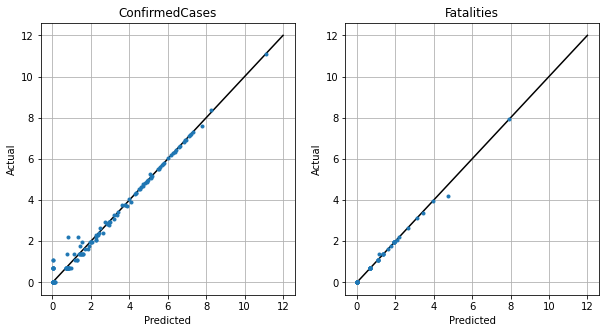



2 x_train (11760, 397)
2 x_val (294, 397)
2 x_full (20580, 397)
2 x_test (294, 397)

****************************************
horizon 2 y0 ConfirmedCases 2020-03-03
****************************************

                  gain
feature               
y0            0.282819
testpop       0.099421
knn6_y0       0.077220
ref_day0_0    0.073359
google_covid  0.053089
extra_y0      0.049228
ref_day0_1    0.046332
wdsp          0.039575
ref_day0_2    0.039575
knn6_y1       0.032819

lgb validation rmse 0.179963

lgb training with full data and predicting 2020-04-02

                      gain
feature                   
y0                0.310680
extra_y0          0.108414
ref_day0_0        0.070388
testpop           0.059061
knn6_y0           0.053398
ref_day0_2        0.051780
ref_day0_1        0.043689
google_covid      0.038026
totalTestResults  0.031553
positive          0.029126

                         gain
feature                      
ref_day0_1           0.922454
y0            

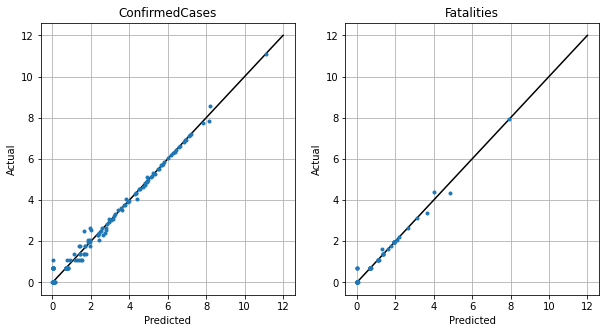



3 x_train (11760, 397)
3 x_val (294, 397)
3 x_full (20580, 397)
3 x_test (294, 397)

****************************************
horizon 3 y0 ConfirmedCases 2020-03-04
****************************************

                     gain
feature                  
y0               0.168099
ref_day0_0       0.077336
testpop          0.075188
google_covid     0.063373
knn6_y0          0.056928
extra_y0         0.040816
min              0.040816
ref_day0_2       0.039742
ref_day0_1       0.032760
Loc_China_Hubei  0.030075

lgb validation rmse 0.285996

lgb training with full data and predicting 2020-04-03

                  gain
feature               
y0            0.136382
ref_day0_0    0.077050
extra_y0      0.075402
knn6_y0       0.066749
google_covid  0.065101
ref_day0_2    0.041615
testpop       0.037907
ref_day0_1    0.037495
min           0.035435
positive      0.034611

                     gain
feature                  
ref_day0_1       0.905924
y1               0.050309
y0          

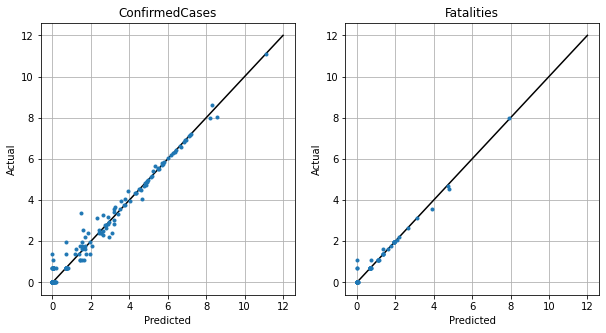



4 x_train (11760, 397)
4 x_val (294, 397)
4 x_full (20580, 397)
4 x_test (294, 397)

****************************************
horizon 4 y0 ConfirmedCases 2020-03-05
****************************************

                  gain
feature               
y0            0.174535
ref_day0_0    0.095136
testpop       0.074392
knn6_y0       0.060086
google_covid  0.052933
min           0.048641
ref_day0_2    0.047926
ref_day0_1    0.043634
extra_y0      0.040773
knn6_y1       0.037196

lgb validation rmse 0.324645

lgb training with full data and predicting 2020-04-04

                  gain
feature               
y0            0.159463
extra_y0      0.083528
google_covid  0.074182
ref_day0_0    0.063084
testpop       0.056659
ref_day0_2    0.056075
knn6_y0       0.056075
ref_day0_1    0.044393
stp           0.032710
positive      0.027453

                      gain
feature                   
ref_day0_1        0.885614
y1                0.047564
y0                0.022149
ref_day0_2       

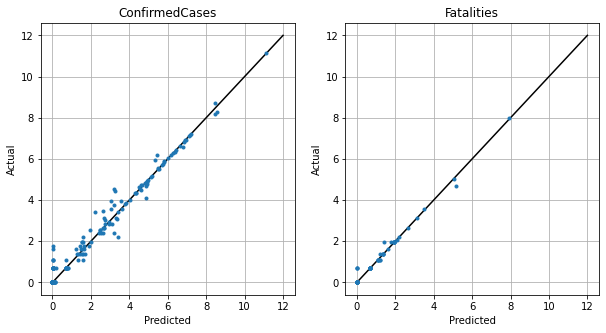



5 x_train (11760, 397)
5 x_val (294, 397)
5 x_full (20580, 397)
5 x_test (294, 397)

****************************************
horizon 5 y0 ConfirmedCases 2020-03-06
****************************************

                  gain
feature               
y0            0.126338
ref_day0_0    0.080835
testpop       0.077623
google_covid  0.063704
min           0.050857
ref_day0_2    0.043362
ref_day0_1    0.039079
knn6_y0       0.038009
stp           0.031049
extra_y0      0.030514

lgb validation rmse 0.390643

lgb training with full data and predicting 2020-04-05

                  gain
feature               
y0            0.110629
google_covid  0.081562
extra_y0      0.076356
ref_day0_0    0.073319
knn6_y0       0.069848
testpop       0.049892
ref_day0_2    0.046421
ref_day0_1    0.037744
min           0.031670
stp           0.028200

                     gain
feature                  
ref_day0_1       0.799728
y1               0.110162
ref_day0_2       0.049683
y0               0.009

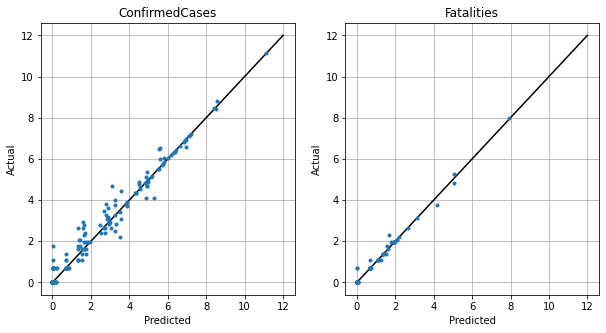



6 x_train (11760, 397)
6 x_val (294, 397)
6 x_full (20580, 397)
6 x_test (294, 397)

****************************************
horizon 6 y0 ConfirmedCases 2020-03-07
****************************************

                  gain
feature               
y0            0.158399
testpop       0.096606
ref_day0_0    0.087903
ref_day0_2    0.060052
ref_day0_1    0.055701
google_covid  0.048738
knn6_y0       0.044386
extra_y0      0.042646
min           0.040905
knn6_y1       0.036554

lgb validation rmse 0.350574

lgb training with full data and predicting 2020-04-06

                  gain
feature               
y0            0.150285
extra_y0      0.096866
ref_day0_0    0.075499
testpop       0.073362
ref_day0_2    0.070513
ref_day0_1    0.056980
knn6_y0       0.055556
google_covid  0.054131
positive      0.037037
ref_day1_2    0.029915

                       gain
feature                    
ref_day0_1         0.830677
y1                 0.090176
ref_day0_2         0.049862
y0          

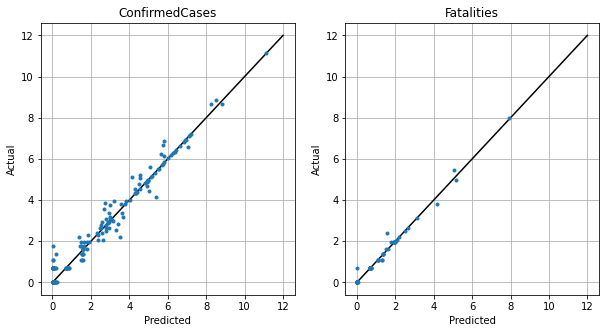



7 x_train (11760, 397)
7 x_val (294, 397)
7 x_full (20580, 397)
7 x_test (294, 397)

****************************************
horizon 7 y0 ConfirmedCases 2020-03-08
****************************************

                  gain
feature               
y0            0.168636
testpop       0.100967
ref_day0_0    0.092374
ref_day0_1    0.075188
ref_day0_2    0.068743
knn6_y0       0.054780
extra_y0      0.053706
google_covid  0.048335
ref_day1_2    0.034372
min           0.033298

lgb validation rmse 0.455691

lgb training with full data and predicting 2020-04-07

                  gain
feature               
y0            0.144029
extra_y0      0.105743
ref_day0_2    0.086600
testpop       0.079307
ref_day0_0    0.076572
ref_day0_1    0.071103
knn6_y0       0.059253
google_covid  0.056518
ref_day1_2    0.041021
positive      0.029170

                     gain
feature                  
ref_day0_1       0.788553
y1               0.103806
ref_day0_2       0.062654
y0               0.007

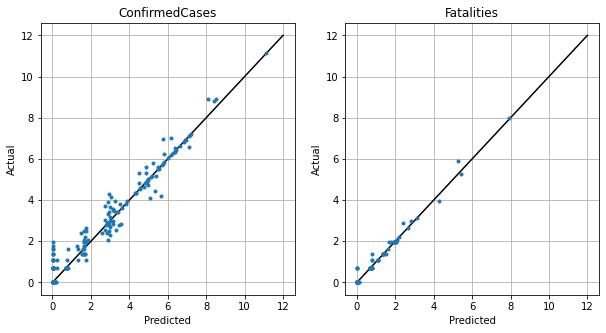



8 x_train (11760, 397)
8 x_val (294, 397)
8 x_full (20580, 397)
8 x_test (294, 397)

****************************************
horizon 8 y0 ConfirmedCases 2020-03-09
****************************************

                  gain
feature               
ref_day0_0    0.099699
y0            0.097194
testpop       0.079158
google_covid  0.068637
ref_day0_2    0.051102
ref_day0_1    0.045090
knn6_y0       0.041082
extra_y0      0.035571
min           0.035070
stp           0.029559

lgb validation rmse 0.373268

lgb training with full data and predicting 2020-04-08

                  gain
feature               
ref_day0_0    0.091824
google_covid  0.078407
extra_y0      0.077568
y0            0.073375
knn6_y0       0.061635
testpop       0.056184
ref_day0_2    0.053669
ref_day0_1    0.037736
max           0.031866
wdsp          0.031447

                                   gain
feature                                
ref_day0_1                     0.844261
ref_day0_2                     0

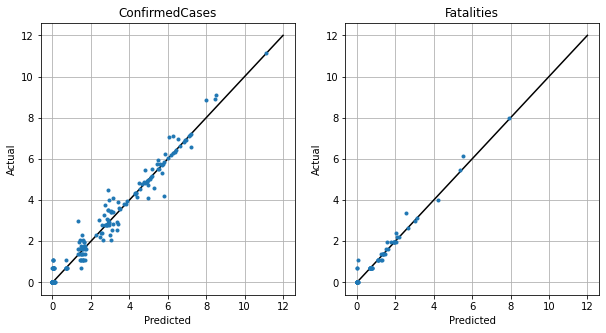



9 x_train (11760, 397)
9 x_val (294, 397)
9 x_full (20580, 397)
9 x_test (294, 397)

****************************************
horizon 9 y0 ConfirmedCases 2020-03-10
****************************************

                  gain
feature               
ref_day0_0    0.116049
y0            0.103704
testpop       0.072840
google_covid  0.067284
ref_day0_2    0.050617
ref_day0_1    0.050617
knn6_y0       0.040741
min           0.038889
extra_y0      0.037037
stp           0.037037

lgb validation rmse 0.965246

lgb training with full data and predicting 2020-04-09

                  gain
feature               
ref_day0_0    0.097336
extra_y0      0.082992
y0            0.076332
google_covid  0.075307
ref_day0_2    0.065574
knn6_y0       0.057377
testpop       0.056352
ref_day0_1    0.043545
min           0.030225
ref_day1_2    0.028689

                      gain
feature                   
ref_day0_1        0.813594
y1                0.063680
ref_day0_2        0.062733
Loc_China_Hubei  

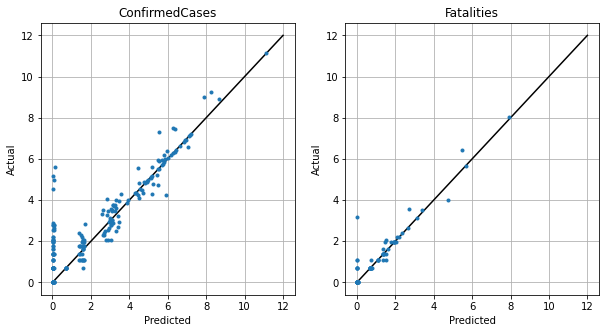



10 x_train (11760, 397)
10 x_val (294, 397)
10 x_full (20580, 397)
10 x_test (294, 397)

****************************************
horizon 10 y0 ConfirmedCases 2020-03-11
****************************************

                  gain
feature               
ref_day0_0    0.120069
y0            0.115780
testpop       0.094340
ref_day0_1    0.070326
ref_day0_2    0.059177
google_covid  0.055746
extra_y0      0.043739
min           0.042024
knn6_y0       0.033448
ref_day1_2    0.031732

lgb validation rmse 0.625240

lgb training with full data and predicting 2020-04-10

                  gain
feature               
y0            0.093706
extra_y0      0.091608
ref_day0_2    0.088112
ref_day0_0    0.080420
testpop       0.079720
ref_day0_1    0.063636
google_covid  0.062937
knn6_y0       0.043357
ref_day1_2    0.040559
stp           0.025175

                     gain
feature                  
ref_day0_1       0.786324
y1               0.088565
ref_day0_2       0.061423
Loc_China_Hubei  

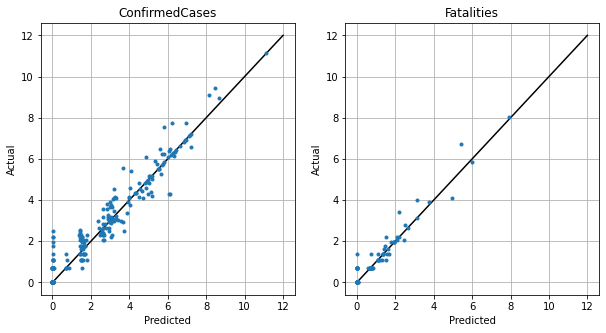



11 x_train (11760, 397)
11 x_val (294, 397)
11 x_full (20580, 397)
11 x_test (294, 397)

****************************************
horizon 11 y0 ConfirmedCases 2020-03-12
****************************************

                  gain
feature               
ref_day0_0    0.126984
y0            0.107143
testpop       0.086508
ref_day0_1    0.068254
ref_day0_2    0.060317
google_covid  0.049206
extra_y0      0.042063
knn6_y0       0.039683
min           0.034921
ref_day1_2    0.028571

lgb validation rmse 0.526209

lgb training with full data and predicting 2020-04-11

                  gain
feature               
ref_day0_0    0.086847
ref_day0_2    0.085588
extra_y0      0.081183
y0            0.076149
testpop       0.076149
google_covid  0.071743
ref_day0_1    0.059157
ref_day1_2    0.043424
knn6_y0       0.042794
min           0.026432

                     gain
feature                  
ref_day0_1       0.812217
ref_day0_2       0.069252
y1               0.040287
Loc_China_Hubei  

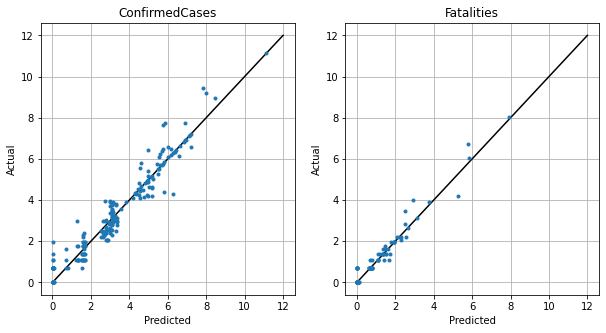



12 x_train (11760, 397)
12 x_val (294, 397)
12 x_full (20580, 397)
12 x_test (294, 397)

****************************************
horizon 12 y0 ConfirmedCases 2020-03-13
****************************************

                  gain
feature               
ref_day0_0    0.102537
y0            0.082452
testpop       0.076638
google_covid  0.063425
ref_day0_2    0.055497
ref_day0_1    0.049683
knn6_y0       0.041755
min           0.034884
extra_y0      0.033827
ref_day1_2    0.030655

lgb validation rmse 0.698960

lgb training with full data and predicting 2020-04-12

                  gain
feature               
ref_day0_0    0.106506
google_covid  0.075839
extra_y0      0.062992
ref_day0_2    0.060506
testpop       0.057605
y0            0.055947
knn6_y0       0.055533
ref_day0_1    0.044343
min           0.033983
ref_day1_2    0.030667

                     gain
feature                  
ref_day0_1       0.807352
y1               0.063428
ref_day0_2       0.056552
Loc_China_Hubei  

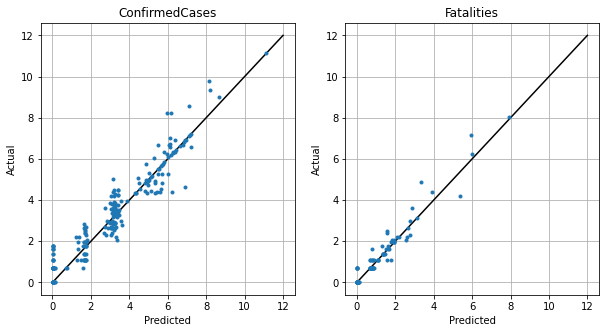



13 x_train (11760, 397)
13 x_val (294, 397)
13 x_full (20580, 397)
13 x_test (294, 397)

****************************************
horizon 13 y0 ConfirmedCases 2020-03-14
****************************************

                gain
feature             
ref_day0_0  0.135949
y0          0.092153
testpop     0.092153
ref_day0_1  0.076642
ref_day0_2  0.069343
knn6_y0     0.045620
ref_day1_2  0.044708
extra_y0    0.036496
min         0.035584
ref_day1_0  0.031934

lgb validation rmse 0.662693

lgb training with full data and predicting 2020-04-13

                  gain
feature               
ref_day0_0    0.092989
ref_day0_2    0.092251
extra_y0      0.086347
y0            0.083395
testpop       0.082657
ref_day0_1    0.063469
google_covid  0.059041
knn6_y0       0.050923
ref_day1_2    0.046494
min           0.029520

                     gain
feature                  
ref_day0_1       0.813224
ref_day0_2       0.076358
Loc_China_Hubei  0.032522
y1               0.010741
knn6_y1        

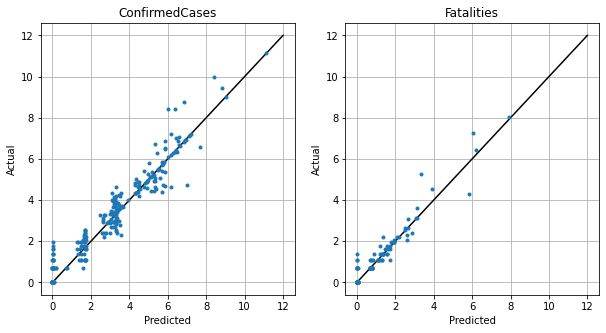



14 x_train (11760, 397)
14 x_val (294, 397)
14 x_full (20580, 397)
14 x_test (294, 397)

****************************************
horizon 14 y0 ConfirmedCases 2020-03-15
****************************************

                gain
feature             
ref_day0_0  0.130682
testpop     0.078977
y0          0.071591
ref_day0_2  0.055682
ref_day0_1  0.052841
knn6_y0     0.049432
ref_day1_2  0.031250
min         0.029545
extra_y0    0.028977
stp         0.028977

lgb validation rmse 0.641337

lgb training with full data and predicting 2020-04-14

                  gain
feature               
ref_day0_0    0.123866
ref_day0_2    0.065336
testpop       0.055808
extra_y0      0.054446
knn6_y0       0.053085
ref_day0_1    0.049456
google_covid  0.048548
y0            0.048548
min           0.041289
stp           0.032214

                     gain
feature                  
ref_day0_1       0.801987
ref_day0_2       0.073611
Loc_China_Hubei  0.044937
y1               0.013347
knn6_y1        

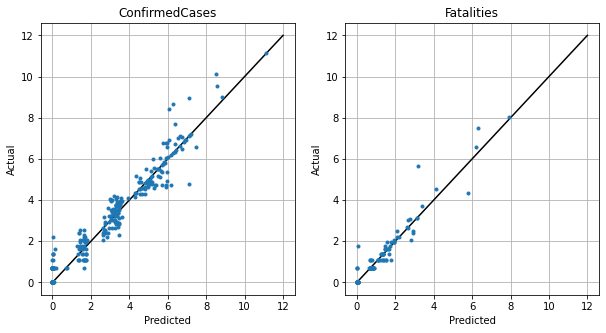



15 x_train (11760, 397)
15 x_val (294, 397)
15 x_full (20580, 397)
15 x_test (294, 397)

****************************************
horizon 15 y0 ConfirmedCases 2020-03-16
****************************************

                gain
feature             
ref_day0_0  0.124559
testpop     0.119859
ref_day0_1  0.083431
y0          0.081081
ref_day0_2  0.081081
extra_y0    0.048179
ref_day1_2  0.043478
knn6_y0     0.036428
stp         0.034078
ref_day1_0  0.032902

lgb validation rmse 0.695307

lgb training with full data and predicting 2020-04-15

                  gain
feature               
ref_day0_2    0.110548
ref_day0_0    0.092292
extra_y0      0.092292
ref_day0_1    0.088235
y0            0.072008
testpop       0.070994
knn6_y0       0.062880
ref_day1_2    0.052738
google_covid  0.044625
ref_day1_0    0.029412

                     gain
feature                  
ref_day0_1       0.812342
ref_day0_2       0.070918
Loc_China_Hubei  0.042350
y1               0.010306
knn6_y1        

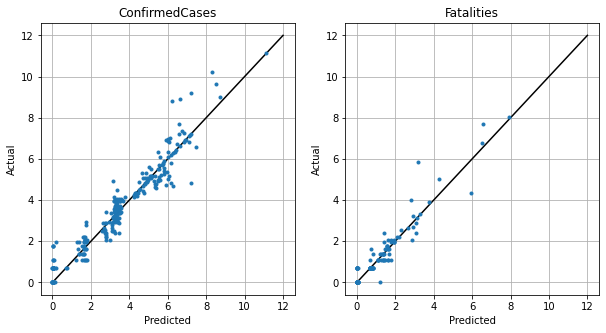



16 x_train (11760, 397)
16 x_val (294, 397)
16 x_full (20580, 397)
16 x_test (294, 397)

****************************************
horizon 16 y0 ConfirmedCases 2020-03-17
****************************************

                  gain
feature               
ref_day0_0    0.126386
testpop       0.123060
ref_day0_2    0.088692
ref_day0_1    0.079823
y0            0.073171
ref_day1_2    0.047672
knn6_y0       0.045455
stp           0.042129
google_covid  0.033259
extra_y0      0.032151

lgb validation rmse 0.762712

lgb training with full data and predicting 2020-04-16

                  gain
feature               
ref_day0_2    0.110244
extra_y0      0.089756
ref_day0_0    0.088780
ref_day0_1    0.077073
y0            0.069268
testpop       0.066341
ref_day1_2    0.059512
google_covid  0.049756
knn6_y0       0.049756
temp          0.030244

                     gain
feature                  
ref_day0_1       0.790308
ref_day0_2       0.081601
Loc_China_Hubei  0.041342
knn6_y1          

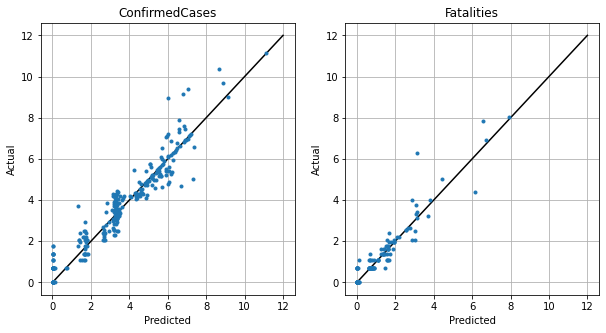



17 x_train (11760, 397)
17 x_val (294, 397)
17 x_full (20580, 397)
17 x_test (294, 397)

****************************************
horizon 17 y0 ConfirmedCases 2020-03-18
****************************************

                     gain
feature                  
ref_day0_0       0.132367
testpop          0.114976
ref_day0_2       0.077295
y0               0.069565
ref_day0_1       0.063768
ref_day1_2       0.045411
knn6_y0          0.041546
stp              0.028986
google_covid     0.028019
Loc_China_Hubei  0.024155

lgb validation rmse 0.692593

lgb training with full data and predicting 2020-04-17

                  gain
feature               
ref_day0_0    0.107283
ref_day0_2    0.097103
extra_y0      0.073610
testpop       0.072044
ref_day0_1    0.072044
y0            0.058731
google_covid  0.057165
ref_day1_2    0.056382
knn6_y0       0.052467
ref_day1_0    0.028191

                     gain
feature                  
ref_day0_1       0.805555
ref_day0_2       0.070784
Loc_Chi

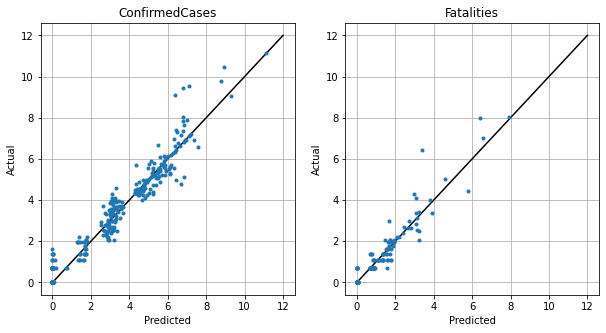



18 x_train (11760, 397)
18 x_val (294, 397)
18 x_full (20580, 397)
18 x_test (294, 397)

****************************************
horizon 18 y0 ConfirmedCases 2020-03-19
****************************************

                  gain
feature               
ref_day0_0    0.118866
testpop       0.115594
ref_day0_2    0.088332
ref_day0_1    0.080698
y0            0.057797
knn6_y0       0.053435
ref_day1_2    0.044711
extra_y0      0.037077
google_covid  0.029444
stp           0.029444

lgb validation rmse 0.772048

lgb training with full data and predicting 2020-04-18

                  gain
feature               
ref_day0_2    0.106250
ref_day0_0    0.095536
testpop       0.084821
ref_day0_1    0.077679
extra_y0      0.073214
google_covid  0.062500
y0            0.060714
ref_day1_2    0.058036
knn6_y0       0.056250
ref_day1_0    0.031250

                     gain
feature                  
ref_day0_1       0.785197
ref_day0_2       0.083784
Loc_China_Hubei  0.037361
y1               

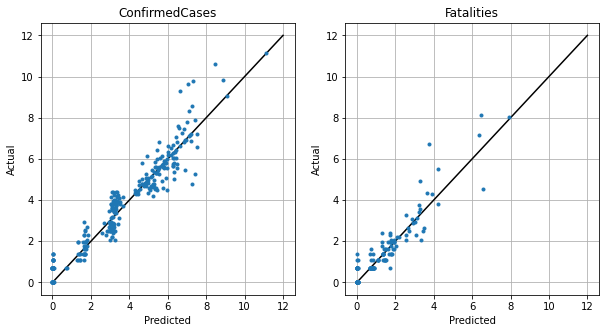



19 x_train (11760, 397)
19 x_val (294, 397)
19 x_full (20580, 397)
19 x_test (294, 397)

****************************************
horizon 19 y0 ConfirmedCases 2020-03-20
****************************************

                     gain
feature                  
ref_day0_0       0.162468
testpop          0.084833
y0               0.066324
ref_day0_2       0.062725
ref_day0_1       0.051928
knn6_y0          0.043188
ref_day1_2       0.028278
google_covid     0.028278
extra_y0         0.025707
Loc_China_Hubei  0.024165

lgb validation rmse 0.803762

lgb training with full data and predicting 2020-04-19

                  gain
feature               
ref_day0_0    0.134231
google_covid  0.064055
ref_day0_2    0.060792
testpop       0.053856
ref_day0_1    0.046512
knn6_y0       0.046512
extra_y0      0.044064
y0            0.042840
ref_day1_2    0.032640
min           0.032232

                            gain
feature                         
ref_day0_1              0.830119
ref_day0_2  

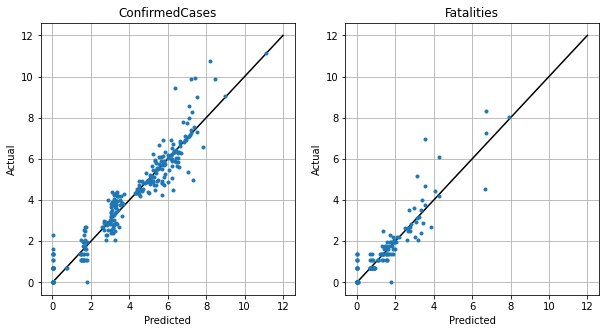



20 x_train (11760, 397)
20 x_val (294, 397)
20 x_full (20580, 397)
20 x_test (294, 397)

****************************************
horizon 20 y0 ConfirmedCases 2020-03-21
****************************************

                     gain
feature                  
ref_day0_0       0.184817
testpop          0.078534
ref_day0_2       0.061780
y0               0.059686
ref_day0_1       0.053403
ref_day1_2       0.034555
Loc_China_Hubei  0.025131
extra_y0         0.024607
stp              0.023037
google_covid     0.022513

lgb validation rmse 0.816449

lgb training with full data and predicting 2020-04-20

                  gain
feature               
ref_day0_0    0.139649
google_covid  0.065333
ref_day0_2    0.064516
testpop       0.048591
ref_day0_1    0.045733
extra_y0      0.043691
y0            0.042466
knn6_y0       0.040833
min           0.040425
ref_day1_2    0.035116

                                   gain
feature                                
ref_day0_1                     

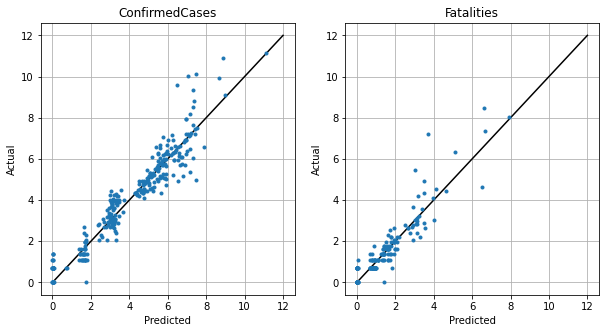



21 x_train (11760, 397)
21 x_val (294, 397)
21 x_full (20580, 397)
21 x_test (294, 397)

****************************************
horizon 21 y0 ConfirmedCases 2020-03-22
****************************************

                  gain
feature               
ref_day0_0    0.137412
testpop       0.116349
ref_day0_2    0.093280
ref_day0_1    0.078235
ref_day1_2    0.045135
stp           0.036108
y0            0.034102
ref_day1_0    0.028084
google_covid  0.028084
extra_y0      0.026078

lgb validation rmse 0.831819

lgb training with full data and predicting 2020-04-21

                  gain
feature               
ref_day0_0    0.100402
ref_day0_2    0.092369
ref_day0_1    0.079518
extra_y0      0.069076
testpop       0.062651
google_covid  0.062651
ref_day1_2    0.054618
y0            0.049799
knn6_y0       0.049799
ref_day1_0    0.034538

                                   gain
feature                                
ref_day0_1                     0.742091
ref_day0_2                 

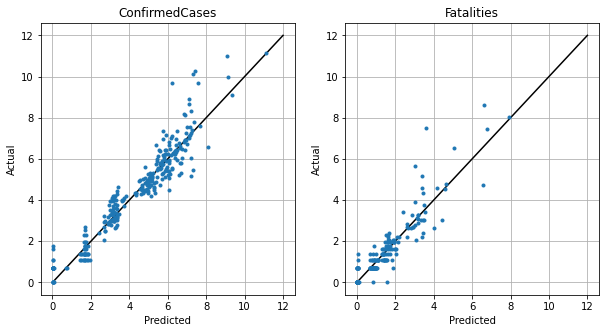



22 x_train (11760, 397)
22 x_val (294, 397)
22 x_full (20580, 397)
22 x_test (294, 397)

****************************************
horizon 22 y0 ConfirmedCases 2020-03-23
****************************************

                     gain
feature                  
ref_day0_0       0.149267
testpop          0.105311
ref_day0_2       0.082418
ref_day0_1       0.073260
ref_day1_2       0.043956
stp              0.035714
Loc_China_Hubei  0.029304
y0               0.028388
google_covid     0.027473
knn6_y0          0.021978

lgb validation rmse 0.869965

lgb training with full data and predicting 2020-04-22

                  gain
feature               
ref_day0_0    0.129054
ref_day0_2    0.084459
ref_day0_1    0.070946
testpop       0.064865
google_covid  0.061486
extra_y0      0.060811
knn6_y0       0.049324
ref_day1_2    0.047973
y0            0.039865
ref_day1_0    0.027027

                                   gain
feature                                
ref_day0_1                     

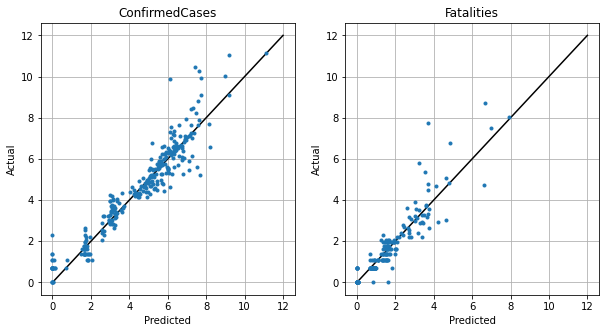



23 x_train (11760, 397)
23 x_val (294, 397)
23 x_full (20580, 397)
23 x_test (294, 397)

****************************************
horizon 23 y0 ConfirmedCases 2020-03-24
****************************************

                        gain
feature                     
ref_day0_0          0.173547
testpop             0.087920
ref_day0_2          0.080275
ref_day0_1          0.063456
ref_day1_2          0.035933
Loc_China_Hubei     0.029052
y0                  0.027523
stp                 0.025229
google_covid        0.024465
Loc_China_Zhejiang  0.020642

lgb validation rmse 0.887025

lgb training with full data and predicting 2020-04-23

                  gain
feature               
ref_day0_0    0.154769
ref_day0_2    0.073672
google_covid  0.063963
ref_day0_1    0.057681
extra_y0      0.052541
testpop       0.049686
ref_day1_2    0.045117
knn6_y0       0.039977
y0            0.037693
temp          0.031411

                        gain
feature                     
ref_day0_1       

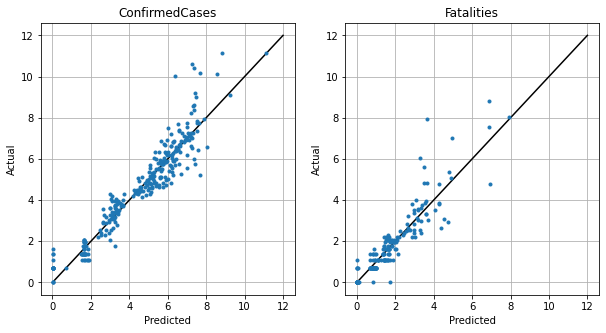



24 x_train (11760, 397)
24 x_val (294, 397)
24 x_full (20580, 397)
24 x_test (294, 397)

****************************************
horizon 24 y0 ConfirmedCases 2020-03-25
****************************************

                     gain
feature                  
testpop          0.125452
ref_day0_0       0.119421
ref_day0_2       0.103739
ref_day0_1       0.098914
ref_day1_2       0.050663
stp              0.036188
y0               0.027744
extra_y0         0.027744
Loc_China_Hubei  0.027744
ref_day1_0       0.026538

lgb validation rmse 0.914387

lgb training with full data and predicting 2020-04-24

                  gain
feature               
ref_day0_2    0.112796
ref_day0_0    0.100474
ref_day0_1    0.085308
google_covid  0.078673
extra_y0      0.072038
testpop       0.067299
ref_day1_2    0.059716
knn6_y0       0.054028
ref_day1_0    0.034123
y0            0.034123

                              gain
feature                           
ref_day0_1                0.843746
ref_da

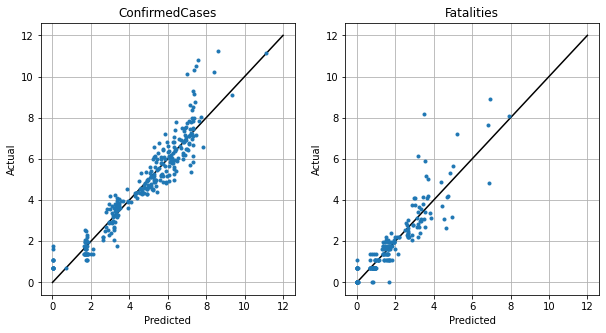



25 x_train (11760, 397)
25 x_val (294, 397)
25 x_full (20580, 397)
25 x_test (294, 397)

****************************************
horizon 25 y0 ConfirmedCases 2020-03-26
****************************************

                        gain
feature                     
ref_day0_0          0.165301
testpop             0.086066
ref_day0_2          0.084016
ref_day0_1          0.058060
ref_day1_2          0.033470
Loc_China_Hubei     0.029372
extra_y0            0.029372
ref_day1_0          0.021858
Loc_China_Zhejiang  0.021858
stp                 0.020492

lgb validation rmse 0.967150

lgb training with full data and predicting 2020-04-25

                  gain
feature               
ref_day0_0    0.176897
ref_day0_2    0.069599
google_covid  0.058482
ref_day0_1    0.055099
testpop       0.049299
extra_y0      0.048816
ref_day1_2    0.044466
knn6_y0       0.037699
min           0.037216
y0            0.028033

                        gain
feature                     
ref_day0_1       

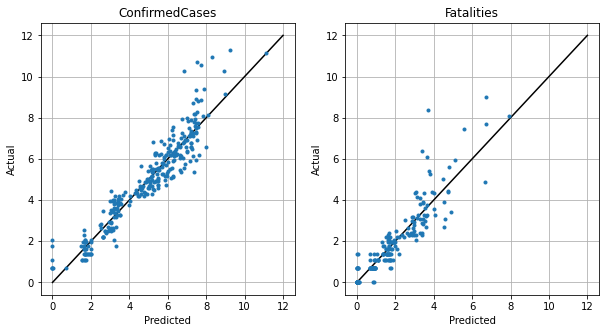



26 x_train (11760, 397)
26 x_val (294, 397)
26 x_full (20580, 397)
26 x_test (294, 397)

****************************************
horizon 26 y0 ConfirmedCases 2020-03-27
****************************************

                      gain
feature                   
ref_day0_0          0.1688
testpop             0.1008
ref_day0_2          0.0816
ref_day0_1          0.0600
ref_day1_2          0.0424
Loc_China_Hubei     0.0280
extra_y0            0.0232
Loc_China_Zhejiang  0.0216
stp                 0.0216
Loc_China_Hunan     0.0208

lgb validation rmse 0.960867

lgb training with full data and predicting 2020-04-26

                  gain
feature               
ref_day0_0    0.162885
ref_day0_2    0.077952
ref_day0_1    0.059337
google_covid  0.056428
testpop       0.055846
extra_y0      0.054101
knn6_y0       0.044212
ref_day1_2    0.040140
ref_day1_0    0.032577
min           0.032577

                        gain
feature                     
ref_day0_1          0.791661
ref_day0_2  

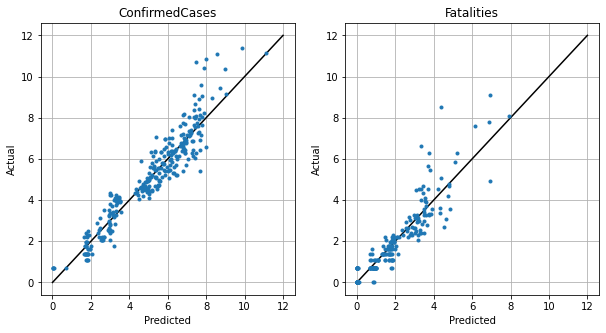



27 x_train (11760, 397)
27 x_val (294, 397)
27 x_full (20580, 397)
27 x_test (294, 397)

****************************************
horizon 27 y0 ConfirmedCases 2020-03-28
****************************************

                    gain
feature                 
testpop          0.12125
ref_day0_0       0.11125
ref_day0_2       0.10000
ref_day0_1       0.09000
ref_day1_2       0.04625
extra_y0         0.03500
stp              0.03500
Loc_China_Hubei  0.02875
google_covid     0.02375
knn6_y0          0.02125

lgb validation rmse 1.033626

lgb training with full data and predicting 2020-04-27

                  gain
feature               
ref_day0_0    0.113529
ref_day0_2    0.111637
ref_day0_1    0.087985
google_covid  0.073794
testpop       0.065279
extra_y0      0.064333
ref_day1_2    0.057711
knn6_y0       0.047304
min           0.034059
ref_day1_0    0.029328

                              gain
feature                           
ref_day0_1                0.838569
ref_day0_2        

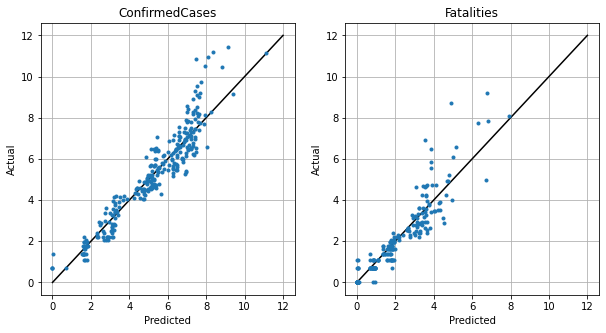



28 x_train (11760, 397)
28 x_val (294, 397)
28 x_full (20580, 397)
28 x_test (294, 397)

****************************************
horizon 28 y0 ConfirmedCases 2020-03-29
****************************************

                     gain
feature                  
ref_day0_0       0.119497
testpop          0.119497
ref_day0_2       0.109434
ref_day0_1       0.089308
ref_day1_2       0.050314
extra_y0         0.035220
google_covid     0.033962
ref_day1_0       0.031447
Loc_China_Hubei  0.026415
stp              0.023899

lgb validation rmse 1.097317

lgb training with full data and predicting 2020-04-28

                  gain
feature               
ref_day0_0    0.110694
ref_day0_2    0.110694
ref_day0_1    0.082552
extra_y0      0.073171
google_covid  0.072233
testpop       0.071295
ref_day1_2    0.056285
knn6_y0       0.041276
ref_day1_0    0.030957
y0            0.025328

                        gain
feature                     
ref_day0_1          0.734548
ref_day0_2          0.08

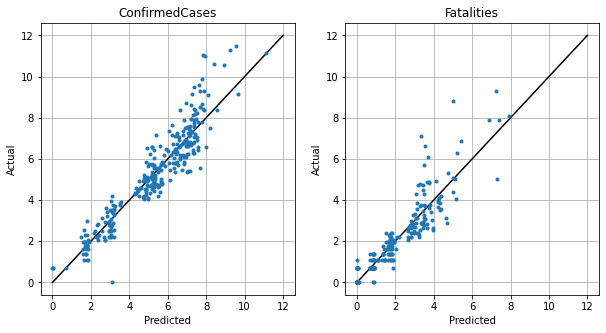



29 x_train (11760, 397)
29 x_val (294, 397)
29 x_full (20580, 397)
29 x_test (294, 397)

****************************************
horizon 29 y0 ConfirmedCases 2020-03-30
****************************************

                     gain
feature                  
testpop          0.126482
ref_day0_2       0.117260
ref_day0_0       0.113307
ref_day0_1       0.090909
ref_day1_2       0.056653
extra_y0         0.047431
knn6_y0          0.025033
Loc_China_Hubei  0.023715
google_covid     0.023715
ref_day1_1       0.019763

lgb validation rmse 1.085788

lgb training with full data and predicting 2020-04-29

                  gain
feature               
ref_day0_0    0.108607
ref_day0_2    0.107582
ref_day0_1    0.090164
extra_y0      0.069672
google_covid  0.066598
testpop       0.062500
ref_day1_2    0.061475
knn6_y0       0.036885
min           0.033811
ref_day1_0    0.027664

                        gain
feature                     
ref_day0_1          0.762425
ref_day0_2          0.06

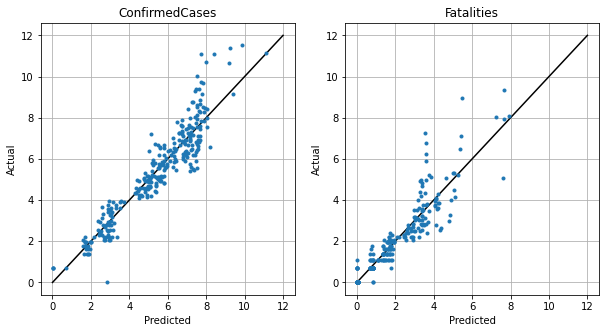



30 x_train (11760, 397)
30 x_val (294, 397)
30 x_full (20580, 397)
30 x_test (294, 397)

****************************************
horizon 30 y0 ConfirmedCases 2020-03-31
****************************************

                        gain
feature                     
ref_day0_0          0.180136
ref_day0_2          0.082048
testpop             0.078347
ref_day0_1          0.064158
extra_y0            0.033930
ref_day1_2          0.031462
Loc_China_Hubei     0.024676
ref_day1_0          0.023442
Loc_China_Zhejiang  0.021592
Loc_China_Hunan     0.020358

lgb validation rmse 1.057158

lgb training with full data and predicting 2020-04-30

                  gain
feature               
ref_day0_0    0.193106
ref_day0_2    0.065400
google_covid  0.057004
extra_y0      0.048608
ref_day0_1    0.045957
testpop       0.041980
ref_day1_2    0.035793
knn6_y0       0.034468
min           0.029607
y0            0.028723

                        gain
feature                     
ref_day0_1       

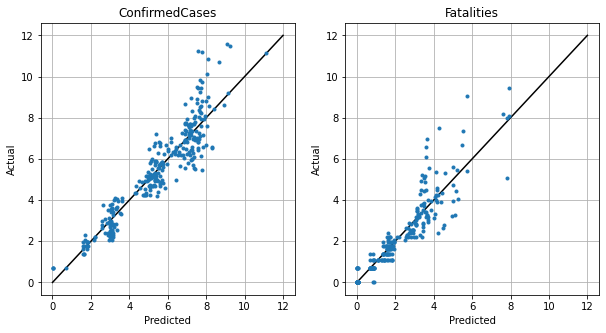


imp/gbt1n_imp.csv (84180, 6)
rez/gbt1n_rallv.npy (30, 2, 3)
rez/gbt1n_nnls.npy (30, 2, 3)


In [78]:
# single horizon validation using one day at a time for 28 days
nb = len(booster)
nls = np.zeros((nhorizon,ny,nb))
rallv = np.zeros((nhorizon,ny,nb))
iallv = np.zeros((nhorizon,ny,nb)).astype(int)
yallv = []
pallv = []
imps = []
 
# loop over horizons
for horizon in range(1+skip,nhorizon+1):
# for horizon in range(4,5):
    
    print()
#     print('*'*20)
#     print(f'horizon {horizon}')
#     print('*'*20)
    
    gc.collect()
    
    hs = str(horizon)
    if horizon < 10: hs = '0' + hs
    
    # build lists of features
    lags = []
    diffs = []
    for i in range(ny):
        yi = 'y'+str(i)
        lags.append(yi)
        lags.append('extra_'+yi)
        lags.append('rate'+str(i))
        lags.append(yi+dd)
        lags.append('extra_'+yi+dd)
        lags.append('rate'+str(i)+dd)
        lags.append(yi+rr)
        lags.append('extra_'+yi+rr)
        lags.append('rate'+str(i)+rr)
        for k in kp:
            lags.append(k+yi)
            lags.append(k+yi+dd)
            lags.append(k+yi+rr)
        for k in kd:
            lags.append(k+yi)
            lags.append(k+yi+dd)
            lags.append(k+yi+rr)
       
    lags.append('recov')
    
    lags = lags + google + wf + ckeep
    
#     cinfo = ['pop', 'tests', 'testpop', 'density', 'medianage',
#        'urbanpop', 'hospibed', 'smokers']
    cinfo0 = ['testpop']
    cinfo1 = ['testpop','medianage']
    
    f0 = dogs + lags + cinfo0 + ohef
    f1 = dogs + lags + cinfo1 + ohef
    
    # remove some features based on validation experiments
    f0 = [f for f in f0 if not f.startswith('knn11') and not f.startswith('kd') \
         and not f.startswith('rate') and not f.endswith(dd) and not f.endswith(rr)]
    f1 = [f for f in f1 if not f.startswith('knn6') and not f.startswith('kd6')]
    
    # remove any duplicates
    # f0 = list(set(f0))
    # f1 = list(set(f1))
    
    features = []
    features.append(f0)
    features.append(f1)
    
    nf = []
    for i in range(ny):
        nf.append(len(features[i]))
        # print(nf[i], features[i][:10])
        
    qtrain = d['Date'] <= ddate.isoformat()

    vdate = ddate + timedelta(days=horizon)
    qval = d['Date'] == vdate.isoformat()
    qvallag = d['Date'] == ddate.isoformat()
    
    x_train = d[qtrain].copy()
    # make y training data monotonic nondecreasing
    y_train = []
    for i in range(ny):
        y_train.append(pd.Series(d.loc[qtrain,['Loc',yv[i]]].groupby('Loc')[yv[i]].cummax()))

    x_val = d[qval].copy()
    y_val = [d.loc[qval,'y0'].copy(), d.loc[qval,'y1'].copy()]
    yallv.append(y_val)
    
    # lag features
    x_train.loc[:,lags] = x_train.groupby('Loc')[lags].transform(lambda x: x.shift(horizon))
    x_val.loc[:,lags] = d.loc[qvallag,lags].values

    print()
    print(horizon, 'x_train', x_train.shape)
    print(horizon, 'x_val', x_val.shape)
    
    if train_full:
        
        qfull = (d['Date'] <= tmax)
        
        tdate = dmax + timedelta(days=horizon)
        qtest = d['Date'] == tdate.isoformat()
        qtestlag = d['Date'] == dmax.isoformat()
    
        x_full = d[qfull].copy()
        
        # make y training data monotonic nondecreasing
        y_full = []
        for i in range(ny):
            y_full.append(pd.Series(d.loc[qfull,['Loc',yv[i]]].groupby('Loc')[yv[i]].cummax()))
        
        x_test = d[qtest].copy()
        
        # lag features
        x_full.loc[:,lags] = x_full.groupby('Loc')[lags].transform(lambda x: x.shift(horizon))
        x_test.loc[:,lags] = d.loc[qtestlag,lags].values

        print(horizon, 'x_full', x_full.shape)
        print(horizon, 'x_test', x_test.shape)

    train_set = []
    val_set = []
    ny = len(y_train)

#     for i in range(ny):
#         train_set.append(xgb.DMatrix(x_train[features[i]], y_train[i]))
#         val_set.append(xgb.DMatrix(x_val[features[i]], y_val[i]))

    gc.collect()

    # loop over multiple targets
    mod = []
    pred = []
    rez = []
    iters = []
    
    for i in range(ny):
#     for i in range(1):
        print()
        print('*'*40)
        print(f'horizon {horizon} {yv[i]} {ynames[i]} {vdate}')
        print('*'*40)
        
        # use catboost only for y1
        # nb = 2 if i==0 else 3
       
        # matrices to store predictions
        vpm = np.zeros((x_val.shape[0],nb))
        tpm = np.zeros((x_test.shape[0],nb))
        
        for b in range(nb):
            
            if booster[b] == 'cas':
                
                x_train['Partition'] = 1
                x_val['Partition'] = 0
                x_cas_all = pd.concat([x_train, x_val], axis=0)
                # make copy of target since it is also used for lags
                x_cas_all['target'] = pd.concat([y_train[i], y_val[i]], axis=0).values
                s.upload(x_cas_all, casout="x_cas_val")

                target = 'target'
                inputs = features[i]
                inputs.append(target)

                s.loadactionset("autotune")
                res=s.autotune.tuneGradientBoostTree (
                    trainOptions = {
                        "table":{"name":'x_cas_val',"where":"Partition=1"},
                        "target":target,
                        "inputs":inputs,
                        "casOut":{"name":"model", "replace":True}
                    },
                    scoreOptions = {
                        "table":{"name":'x_cas_val', "where":"Partition=0"},
                        "model":{"name":'model'},
                        "casout":{"name":"x_valid_preds","replace":True},
                        "copyvars": ['Id','Loc','Date']
                    },
                    tunerOptions = {
                        "seed":54321,  
                        "objective":"RASE", 
                        "userDefinedPartition":True 
                    }
                )
                print()
                print(res.TunerSummary)
                print()
                print(res.BestConfiguration)        

                TunerSummary=pd.DataFrame(res['TunerSummary'])
                TunerSummary["Value"]=pd.to_numeric(TunerSummary["Value"])
                BestConf=pd.DataFrame(res['BestConfiguration'])
                BestConf["Value"]=pd.to_numeric(BestConf["Value"])
                vpt = s.CASTable("x_valid_preds").to_frame()
                #FG: resort the CAS predictions by Id
                vpt = vpt.sort_values(['Loc','Date']).reset_index(drop=True)
                vp = vpt['P_target'].values

                s.dropTable("x_cas_val")
                s.dropTable("x_valid_preds")
                
            else:
                # scikit interface automatically uses best model for predictions
                params[(booster[b],yv[i])]['n_estimators'] = 5000
                if booster[b]=='lgb':
                    model = lgb.LGBMRegressor(**params[(booster[b],yv[i])]) 
                elif booster[b]=='xgb':
                    model = xgb.XGBRegressor(**params[(booster[b],yv[i])])
                else:
                    # hack for categorical features, ctb must be last in booster list
                    features[i] = features[i][:-294] + ['Loc']
                    params[(booster[b],yv[i])]['cat_features'] = ['Loc']
                    model = ctb.CatBoostRegressor(**params[(booster[b],yv[i])])
                    
                model.fit(x_train[features[i]], y_train[i],
                                  eval_set=[(x_train[features[i]], y_train[i]),
                                            (x_val[features[i]], y_val[i])],
                                  early_stopping_rounds=30,
                                  verbose=False)

                vp = model.predict(x_val[features[i]])
                
                iallv[horizon-1,i,b] = model._best_iteration if booster[b]=='lgb' else \
                                       model.best_iteration if booster[b]=='xgb' else \
                                       model.best_iteration_

                gain = model.feature_importances_
        #         gain = model.get_score(importance_type='gain')
        #         split = model.get_score(importance_type='weight')   
            #     gain = model.feature_importance(importance_type='gain')
            #     split = model.feature_importance(importance_type='split').astype(float)  
            #     imp = pd.DataFrame({'feature':features,'gain':gain,'split':split})
                imp = pd.DataFrame({'feature':features[i],'gain':gain})
        #         imp = pd.DataFrame({'feature':features[i]})
        #         imp['gain'] = imp['feature'].map(gain)
        #         imp['split'] = imp['feature'].map(split)

                imp.set_index(['feature'],inplace=True)

                imp.gain /= np.sum(imp.gain)
        #         imp.split /= np.sum(imp.split)

                imp.sort_values(['gain'], ascending=False, inplace=True)

                print()
                print(imp.head(n=10))
                # print(imp.shape)

                imp.reset_index(inplace=True)
                imp['horizon'] = horizon
                imp['target'] = yv[i]
                imp['set'] = 'valid'
                imp['booster'] = booster[b]

                mod.append(model)
                imps.append(imp)
                
            # china rule, last observation carried forward, set to zero here
            qcv = (x_val['Country_Region'] == 'China') & \
                  (x_val['Province_State'] != 'Hong Kong') & \
                  (x_val['Province_State'] != 'Macau')
            vp[qcv] = 0.0

            # make sure horizon 1 prediction is not smaller than first lag
            # because we know series is monotonic
            # if horizon==1+skip:
            if True:
                a = np.zeros((len(vp),2))
                a[:,0] = vp
                a[:,1] = x_val[yv[i]].values
                vp = np.nanmax(a,axis=1)
            
            val_score = np.sqrt(mean_squared_error(vp, y_val[i]))
            vpm[:,b] = vp
            
            print()
            print(f'{booster[b]} validation rmse {val_score:.6f}')
            rallv[horizon-1,i,b] = val_score

            gc.collect()
    
#             break

            if train_full:
                
                print()
                print(f'{booster[b]} training with full data and predicting', tdate.isoformat())
                    
                if booster[b] == 'cas':
                    
                    x_full['target'] = y_full[i].values
                    s.upload(x_full, casout="x_full")
                    # use hyperparameters from validation fit
                    s.loadactionset("decisionTree")
                    result = s.gbtreetrain(
                        table={"name":'x_full'},
                        target=target,
                        inputs= inputs,
                        varimp=True,
                        ntree=BestConf.iat[0,2], 
                        m=BestConf.iat[1,2],
                        learningRate=BestConf.iat[2,2],
                        subSampleRate=BestConf.iat[3,2],
                        lasso=BestConf.iat[4,2],
                        ridge=BestConf.iat[5,2],
                        nbins=BestConf.iat[6,2],
                        maxLevel=BestConf.iat[7,2],
                        #quantileBin=True,
                        seed=326146718,
                        #savestate={"name":"aStore","replace":True}
                        casOut={"name":'fullmodel', "replace":True}
                        ) 

                    s.upload(x_test, casout="x_test_cas")

                    s.decisionTree.gbtreeScore(
                        modelTable={"name":"fullmodel"},        
                        table={"name":"x_test_cas"},
                        casout={"name":"x_test_preds","replace":True},
                        copyvars= ['Loc','Date']
                        ) 
                    # save test predictions back into main table
                    forecast = s.CASTable("x_test_preds").to_frame()
                    forecast = forecast.sort_values(['Loc','Date']).reset_index(drop=True)
                    tp = forecast['_GBT_PredMean_'].values
                    
                    s.dropTable("x_full")
                    s.dropTable("x_test_cas")
                     
                else:
                
                    # use number of iterations from validation fit
                    params[(booster[b],yv[i])]['n_estimators'] = iallv[horizon-1,i,b]
                    if booster[b]=='lgb':
                        model = lgb.LGBMRegressor(**params[(booster[b],yv[i])])
                    elif booster[b]=='xgb':
                        model = xgb.XGBRegressor(**params[(booster[b],yv[i])])
                    else:
                        model = ctb.CatBoostRegressor(**params[(booster[b],yv[i])])
                    
                    model.fit(x_full[features[i]], y_full[i], verbose=False)
                    
                    params[(booster[b],yv[i])]['n_estimators'] = 5000

                    tp = model.predict(x_test[features[i]])
                
                    gain = model.feature_importances_
            #         gain = model.get_score(importance_type='gain')
            #         split = model.get_score(importance_type='weight')   
                #     gain = model.feature_importance(importance_type='gain')
                #     split = model.feature_importance(importance_type='split').astype(float)  
                #     imp = pd.DataFrame({'feature':features,'gain':gain,'split':split})
                    imp = pd.DataFrame({'feature':features[i],'gain':gain})
            #         imp = pd.DataFrame({'feature':features[i]})
            #         imp['gain'] = imp['feature'].map(gain)
            #         imp['split'] = imp['feature'].map(split)

                    imp.set_index(['feature'],inplace=True)

                    imp.gain /= np.sum(imp.gain)
            #         imp.split /= np.sum(imp.split)

                    imp.sort_values(['gain'], ascending=False, inplace=True)

                    print()
                    print(imp.head(n=10))
                    # print(imp.shape)

                    imp.reset_index(inplace=True)
                    imp['horizon'] = horizon
                    imp['target'] = yv[i]
                    imp['set'] = 'full'
                    imp['booster'] = booster[b]

                    imps.append(imp)

                # china rule, last observation carried forward, set to zero here
                qct = (x_test['Country_Region'] == 'China') & \
                      (x_test['Province_State'] != 'Hong Kong') & \
                      (x_test['Province_State'] != 'Macau')
                tp[qct] = 0.0

                # make sure first horizon prediction is not smaller than first lag
                # because we know series is monotonic
                # if horizon==1+skip:
                if True:
                    a = np.zeros((len(tp),2))
                    a[:,0] = tp
                    a[:,1] = x_test[yv[i]].values
                    tp = np.nanmax(a,axis=1)

                tpm[:,b] = tp
                
                gc.collect()
                
        # nonnegative least squares to estimate ensemble weights
        x, rnorm = nnls(vpm, y_val[i])
        
        nls[horizon-1,i] = x
        
        val_pred = np.matmul(vpm, x)
        test_pred = np.matmul(tpm, x)
        
        # china rule in case weights do not sum to 1
        val_pred[qcv] = vpm[:,0][qcv]
        test_pred[qcv] = tpm[:,0][qct]
        
        # save validation and test predictions back into main table
        d.loc[qval,yv[i]+'_pred'] = val_pred
        d.loc[qtest,yv[i]+'_pred'] = test_pred

        # ensemble validation score
        # val_score = np.sqrt(rnorm/vpm.shape[0])
        val_score = np.sqrt(mean_squared_error(val_pred, y_val[i]))
        
        rez.append(val_score)
        pred.append(val_pred)

    pallv.append(pred)
    
    # nnls weights
    w0 = ''
    w1 = ''
    for b in range(nb):
        w0 = w0 + f' {nls[horizon-1,0,b]:.2f}'
        w1 = w1 + f' {nls[horizon-1,1,b]:.2f}'
        
    print()
    print('Validation RMSLE')
    print(f'{ynames[0]} \t {rez[0]:.6f}  ' + w0)
    print(f'{ynames[1]} \t {rez[1]:.6f}  ' + w1)
    print(f'Mean \t \t {np.mean(rez):.6f}')

#     # break down RMSLE by day
#     rp = np.zeros((2,7))
#     for i in range(ny):
#         for di in range(50,57):
#             j = di - 50
#             qf = x_val.dint == di
#             rp[i,j] = np.sqrt(mean_squared_error(pred[i][qf], y_val[i][qf]))
#             print(i,di,f'{rp[i,j]:.6f}')
#         print(i,f'{np.mean(rp[i,:]):.6f}')
#         plt.plot(rp[i])
#         plt.title(ynames[i] + ' RMSLE')
#         plt.show()
        
    # plot actual vs predicted
    plt.figure(figsize=(10, 5))
    for i in range(ny):
        plt.subplot(1,2,i+1)
        plt.plot([0, 12], [0, 12], 'black')
        plt.plot(pred[i], y_val[i], '.')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(ynames[i])
        plt.grid()
    plt.show()
    
# save one big table of importances
impall = pd.concat(imps)

# remove number suffixes from lag names to aid in analysis
# impall['feature1'] = impall['feature'].replace(to_replace='lag..', value='lag', regex=True)

os.makedirs('imp', exist_ok=True)
fname = 'imp/' + mname + '_imp.csv'
impall.to_csv(fname, index=False)
print()
print(fname, impall.shape)

# save scores and weights
os.makedirs('rez', exist_ok=True)
fname = 'rez/' + mname+'_rallv.npy'
np.save(fname, rallv)
print(fname, rallv.shape)

fname = 'rez/' + mname+'_nnls.npy'
np.save(fname, nls)
print(fname, nls.shape)

In [79]:
if 'cas' in booster: s.shutdown()

In [80]:
tdate.isoformat()

'2020-04-30'

In [81]:
rf = [f for f in features[0] if f.startswith('ref')]
d[rf].describe()

,ref_day0_0,ref_day0_1,ref_day0_2,ref_day1_0,ref_day1_1,ref_day1_2
count,29000.000000,27500.000000,21900.000000,21800.000000,18200.000000,11500.000000
mean,19.033069,16.927418,14.559132,13.085459,11.430604,8.904870
std,23.615022,22.262368,20.482990,19.013519,17.273296,14.394205
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,5.000000,1.000000,0.000000,0.000000,0.000000
75%,34.000000,30.000000,26.000000,23.000000,21.000000,16.000000
max,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000


In [82]:
np.mean(iallv, axis=0)

array([[ 86.366667,  51.666667, 351.3     ],
       [186.566667,  40.1     , 192.7     ]])

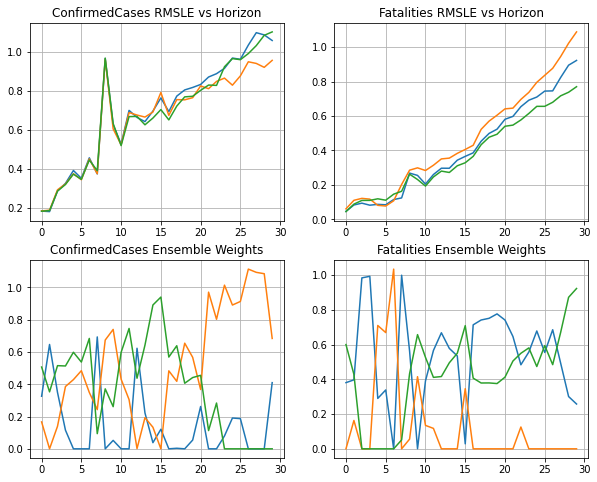

In [83]:
plt.figure(figsize=(10, 8))
for i in range(ny):
    plt.subplot(2,2,1+i)
    plt.plot(rallv[:,i])
    plt.title(ynames[i] + ' RMSLE vs Horizon')
    plt.grid()
    
    plt.subplot(2,2,3+i)
    plt.plot(nls[:,i])
    plt.title(ynames[i] + ' Ensemble Weights')
    plt.grid()
plt.show()

In [84]:
# compute validation rmsle
m = 0
locs = d.loc[:,['Loc','Country_Region','Province_State']].drop_duplicates().reset_index(drop=True)
# locs = x_val.copy().reset_index(drop=True)
# print(locs.shape)
y_truea = []
y_preda = []

print(f'# {mname}')
for i in range(ny):
    y_true = []
    y_pred = []
    for j in range(nhorizon-skip):
        y_true.append(yallv[j][i])
        y_pred.append(pallv[j][i])
    y_true = np.stack(y_true)
    y_pred = np.stack(y_pred)
    # print(y_pred.shape)
    # make each series monotonic increasing
    for j in range(y_pred.shape[1]): 
        y_pred[:,j] = np.maximum.accumulate(y_pred[:,j])
    # copy updated predictions into main table
    for horizon in range(1+skip,nhorizon+1):
        vdate = ddate + timedelta(days=horizon)
        qval = d['Date'] == vdate.isoformat()
        d.loc[qval,yv[i]+'_pred'] = y_pred[horizon-1-skip]
    rmse = np.sqrt(mean_squared_error(y_pred, y_true))
    print(f'# {rmse:.6f}')
    m += rmse/2
    locs['rmse'+str(i)] = np.sqrt(np.mean((y_true-y_pred)**2, axis=0))
    y_truea.append(y_true)
    y_preda.append(y_pred)
print(f'# {m:.6f}')

# gbt1n
# 0.601828
# 0.384629
# 0.493228


In [85]:
# gbt1n
# 0.600095
# 0.387755
# 0.493925

In [86]:
# sort to find worst predictions of y0
locs = locs.sort_values('rmse0', ascending=False)
locs[:10]

,Loc,Country_Region,Province_State,rmse0,rmse1
108,France,France,,2.222798,0.979795
121,Germany,Germany,,2.202618,0.529113
257,US New York,US,New York,2.003534,0.714738
209,Spain,Spain,,1.977568,2.765573
199,San Marino,San Marino,,1.732741,0.987191
137,Iraq,Iraq,,1.626928,0.492079
147,Kuwait,Kuwait,,1.504279,0.079244
140,Italy,Italy,,1.348139,1.418893
94,Diamond Princess,Diamond Princess,,1.151434,0.863729
281,United Kingdom,United Kingdom,,1.101362,1.946800


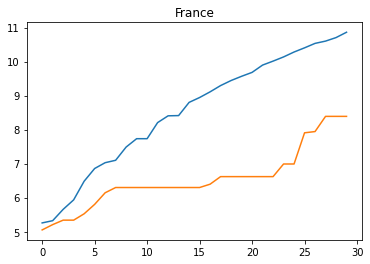

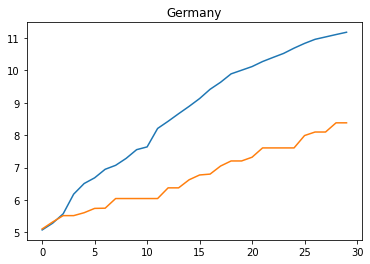

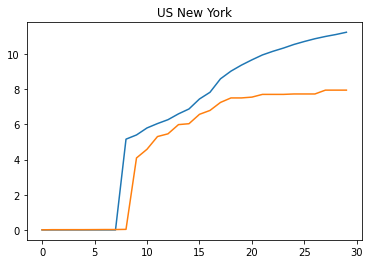

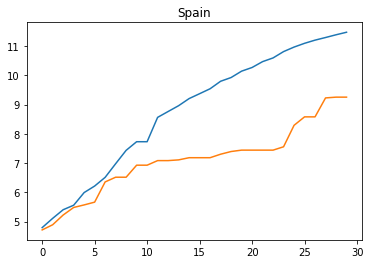

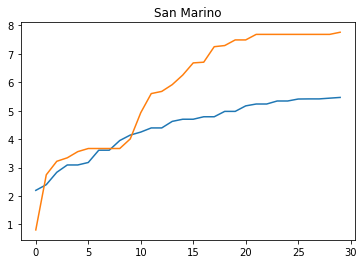

In [87]:
# plot worst fits of y0
for i in range(5):
    li = locs.index[i]
    plt.plot(y_truea[0][:,li])
    plt.plot(y_preda[0][:,li])
    plt.title(locs.loc[li,'Loc'])
    plt.show()

In [88]:
# sort to find worst predictions of y1
locs = locs.sort_values('rmse1', ascending=False)
locs[:10]

,Loc,Country_Region,Province_State,rmse0,rmse1
209,Spain,Spain,,1.977568,2.765573
281,United Kingdom,United Kingdom,,1.101362,1.946800
146,"Korea, South","Korea, South",,0.267965,1.609886
173,Netherlands,Netherlands,,0.928151,1.486258
140,Italy,Italy,,1.348139,1.418893
23,Belgium,Belgium,,1.022866,1.106602
37,Canada British Columbia,Canada,British Columbia,0.821805,1.035307
199,San Marino,San Marino,,1.732741,0.987191
108,France,France,,2.222798,0.979795
214,Switzerland,Switzerland,,1.016669,0.969883


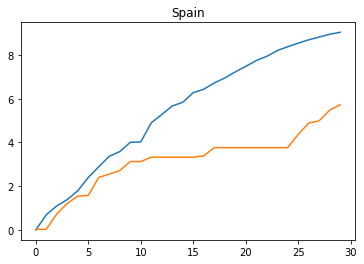

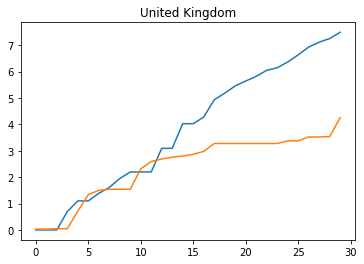

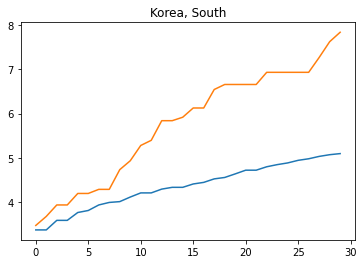

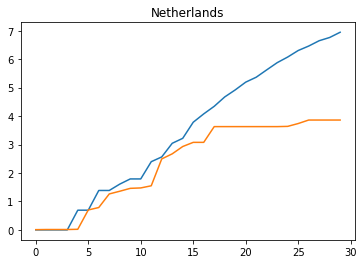

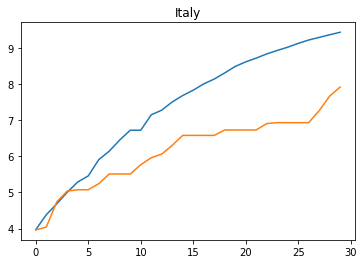

In [89]:
# plot worst fits of y1
for i in range(5):
    li = locs.index[i]
    plt.plot(y_truea[1][:,li])
    plt.plot(y_preda[1][:,li])
    plt.title(locs.loc[li,'Loc'])
    plt.show()

In [90]:
tmax

'2020-03-31'

In [91]:
# enforce monotonicity of forecasts in test set after last date in training
loc = d['Loc'].unique()
for l in loc:
    # q = (d.Loc==l) & (d.ForecastId > 0)
    q = (d.Loc==l) & (d.Date > tmax)
    for yi in yv:
        yp = yi+'_pred'
        d.loc[q,yp] = np.maximum.accumulate(d.loc[q,yp])

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


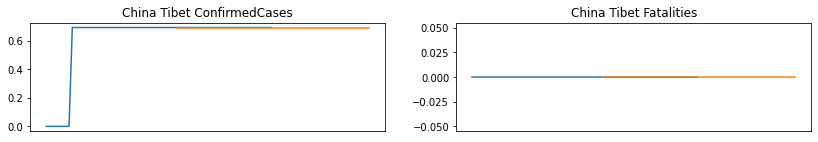

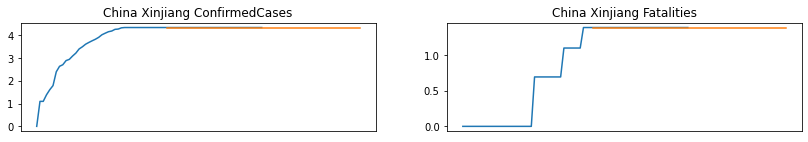

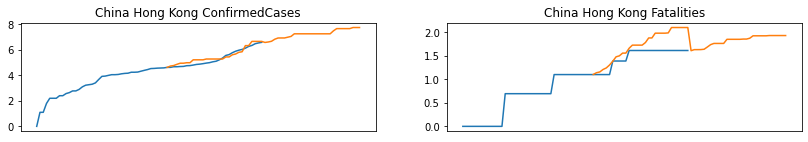

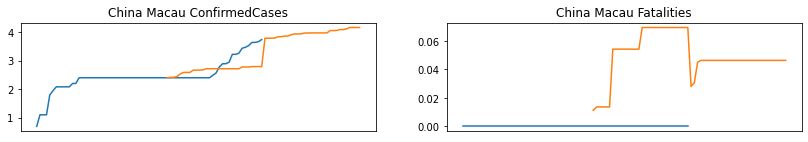

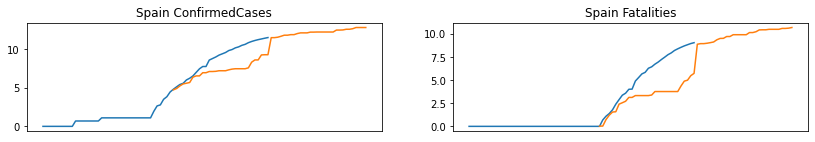

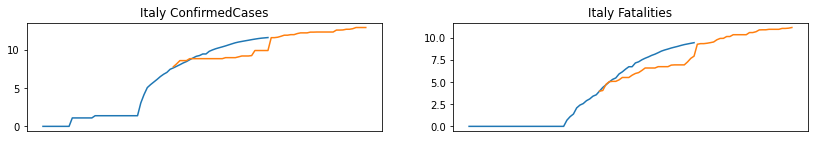

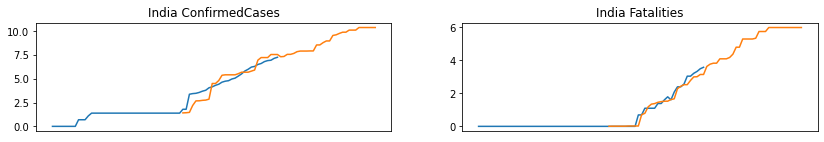

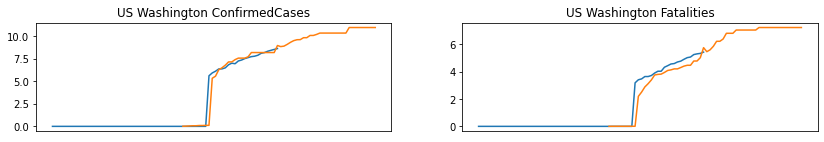

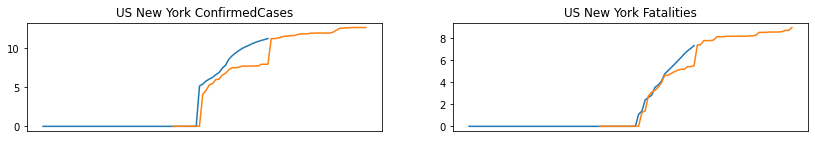

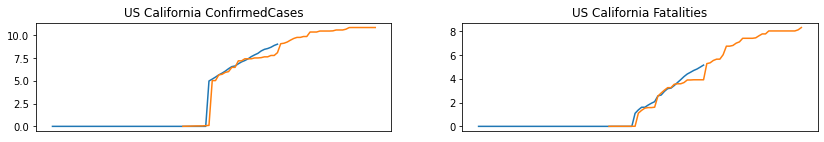

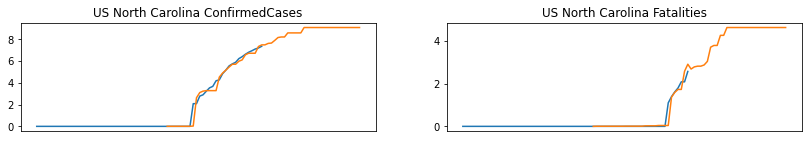

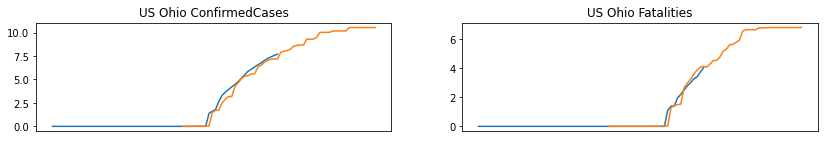

In [92]:
# plot actual and predicted curves over time for specific locations
locs = ['China Tibet','China Xinjiang','China Hong Kong', 'China Macau',
        'Spain','Italy','India',
        'US Washington','US New York','US California',
        'US North Carolina','US Ohio']
xlab = ['03-12','03-18','03-25','04-01','04-08','04-15','04-22']
for loc in locs:
    plt.figure(figsize=(14,2))
    
    # fig, ax = plt.subplots()
    # fig.autofmt_xdate()
    
    for i in range(ny):
    
        plt.subplot(1,2,i+1)
        plt.plot(d.loc[d.Loc==loc,[yv[i],'Date']].set_index('Date'))
        plt.plot(d.loc[d.Loc==loc,[yv[i]+'_pred','Date']].set_index('Date'))
        # plt.plot(d.loc[d.Loc==loc,[yv[i]]])
        # plt.plot(d.loc[d.Loc==loc,[yv[i]+'_pred']])
        # plt.xticks(np.arange(len(xlab)), xlab, rotation=-45)
        # plt.xticks(np.arange(12), calendar.month_name[3:5], rotation=20)
        # plt.xticks(rotation=-45)
        plt.xticks([])
        plt.title(loc + ' ' + ynames[i])
       
    plt.show()

In [93]:
pd.set_option('display.max_rows', 100)
loc = 'China Xinjiang'
d.loc[d.Loc==loc,['Date',yv[0],yv[0]+'_pred']]

,Date,y0,y0_pred
7900,2020-01-22,0.000000,NaN
7901,2020-01-23,1.098612,NaN
7902,2020-01-24,1.098612,NaN
7903,2020-01-25,1.386294,NaN
7904,2020-01-26,1.609438,NaN
7905,2020-01-27,1.791759,NaN
7906,2020-01-28,2.397895,NaN
7907,2020-01-29,2.639057,NaN
7908,2020-01-30,2.708050,NaN
7909,2020-01-31,2.890372,NaN


In [94]:
tmax

'2020-03-31'

In [95]:
fmin

'2020-03-19'

In [96]:
# compute public lb score
q = (d.Date >= fmin) & (d.Date <= tmax)
print(f'# {tmax} {sum(q)/ns} {mname}')
s0 = np.sqrt(mean_squared_error(d.loc[q,'y0'],d.loc[q,'y0_pred']))
s1 = np.sqrt(mean_squared_error(d.loc[q,'y1'],d.loc[q,'y1_pred']))
print(f'# CC \t {s0:.6f}')
print(f'# Fa \t {s1:.6f}')
print(f'# Mean \t {(s0+s1)/2:.6f}')

# 2020-03-31 13.0 gbt1n
# CC 	 0.705227
# Fa 	 0.540742
# Mean 	 0.622984


In [97]:
# 2020-03-31 13.0 gbt1n
# CC 	 0.706017
# Fa 	 0.545857
# Mean 	 0.625937

In [98]:
# create submission
sub = d.loc[d.ForecastId > 0, ['ForecastId','y0_pred','y1_pred']]
sub['ConfirmedCases'] = np.expm1(sub['y0_pred'])
sub['Fatalities'] = np.expm1(sub['y1_pred'])
sub.drop(['y0_pred','y1_pred'],axis=1,inplace=True)
os.makedirs('sub',exist_ok=True)
# fname = 'sub/' + mname + '.csv'
fname = 'submission.csv'
sub.to_csv(fname, index=False)
print(fname, sub.shape)

submission.csv (12642, 3)


In [99]:
sub

,ForecastId,ConfirmedCases,Fatalities
57,1,32.096363,0.023349
58,2,36.413234,0.023349
59,3,36.413234,0.023349
60,4,40.756098,0.049769
61,5,40.756098,1.404162
...,...,...,...
29395,12638,27.265837,1.306397
29396,12639,27.265837,1.306397
29397,12640,27.265837,1.306397
29398,12641,27.265837,1.306397


In [100]:
# save predictions
ovars = ['Id','ForecastId','Country_Region','State_Provice','Loc','y0','y1','y0_pred','y1_pred']
oof = d.loc[:,ovars]
oof = oof.rename(mapper={'y0_pred':mname+'0','y1_pred':mname+'1'}, axis=1)
os.makedirs('oof',exist_ok=True)
fname = 'oof/' + mname + '.csv'
oof.to_csv(fname, index=False)
print(fname, oof.shape)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


oof/gbt1n.csv (29400, 9)


In [101]:
if save_data:
    os.makedirs('data',exist_ok=True)
    fname = 'data/' + mname + '_d.csv'
    d.to_csv(fname, index=False)
    print(fname, d.shape)